# 0. IMPORTS

## 0.1 Import Libraries

In [82]:
import math
import datetime
import inflection
import warnings
import random
import pickle

import pandas            as pd
import numpy             as np
import seaborn           as sns
import researchpy        as rp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xgboost           as xgb

from matplotlib.gridspec     import GridSpec
from IPython.display         import Image
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.metrics         import mean_absolute_error,  mean_absolute_percentage_error,  mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from boruta                  import BorutaPy

## 0.2 Set Paramemters

In [2]:
# Set figure features
plt.rcParams['figure.figsize'] = (20, 8)

# Set seaborn parameters
sns.set_theme(context='notebook', palette='pastel')

# Ignore alers
warnings.filterwarnings('ignore')

# Set number format style
formatter = ticker.StrMethodFormatter("{x:,.0f}")

## 0.3 Loading Data

In [3]:
# Load sales dataframe
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)

# Load some store information
df_stores_raw = pd.read_csv('data/store.csv', low_memory=False)

# Merge dataframes to increase store information
df_raw = pd.merge(df_sales_raw, df_stores_raw, how='left', on='Store')

We have more than 1k stores, but in order to make the project faster and less heavy, we will select only the 300 stores, selecting them randomly.

In [4]:
# create a random sample to select 300 stores
random.seed(1)

start = 1
finish = 1115
sample_size = 300

stores = random.sample(range(start, finish+1), sample_size)

# create dataframe
df_raw = df_raw.loc[df_raw['Store'].isin(stores), :].reset_index(drop=True)

# 1. FUNCTIONS

In [5]:
def fill_nas(dataset):
    '''
    Function that performs the filling of missing data
    
    Parameters: 
        dataset: the dataset with the project data
    Returns:
        The project dataframe with the all previous missing data filled out

    '''
    # make a copy of the dataset
    df = dataset.copy()
    
    # competition_distance (fill out with extreme values, assuming that null values does not have close competitor)
    df['competition_distance'] = df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
    
    # competition_open_since_month 
    df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
                                                  else x['competition_open_since_month'], axis=1)
    
    # competition_open_since_year
    df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                                 else x['competition_open_since_year'], axis=1)
    
    # promo2_since_week
    df['promo2_since_week'] = df.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                                    else x['promo2_since_week'], axis = 1)
    
    # promo2_since_year
    df['promo2_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                                    else x['promo2_since_year'], axis = 1)
    
    # promo_interval
    months = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11: 'Nov', 12: 'Dec'}
    df['promo_interval'].fillna(0, inplace=True)
    df['month_map'] = df['date'].dt.month.map(months)
    
    df['is_promo'] = df.apply(lambda x: 0 if x['promo_interval'] == 0 
                              else 1 if x['month_map'] in x['promo_interval'].split(',') 
                              else 0, axis=1)

    return df

In [6]:
def feature_engineering(dataset):
    '''
    Function that creates or change the nature of features

    Parameters: 
        dataset: the dataset with the project data
    Returns:
        The project dataframe with the all derived and changed features
        
    '''
    df = dataset.copy()
    
    # year
    df['year'] = df['date'].dt.year
    
    # month
    df['month'] = df['date'].dt.month
    
    # week
    df['week'] = df['date'].dt.isocalendar().week
    
    # day
    df['day'] = df['date'].dt.day
    
    # year-week
    df['year_week'] = df['date'].dt.strftime('%Y-%W')
    
    # Competition since date
    df['competition_since_date'] = df.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                                                        month=x['competition_open_since_month'], 
                                                                        day=1), axis=1)
    
    # Number of months in competition
    df['competition_number_months'] = (((df['date'] - df['competition_since_date']).dt.days)/30).astype(int)
    
    # Promo since
    df['promo_since'] = df['promo2_since_year'].astype(str) + '-' + df['promo2_since_week'].astype(str)
    df['promo_since'] = df['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
    
    # Number of weeks in promo
    df['promo_number_weeks'] = (((df['date'] - df['promo_since']).dt.days)/7).astype(int)
    
    # Assortment
    df['assortment'] = df['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
    
    # State Holiday
    df['state_holiday'] = df['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                              'easter_holiday' if x == 'b' else 
                                                              'christmas' if x == 'c' else 
                                                              'no_holiday')

    return df

In [7]:
def cramers_v(data, x, y):
    '''
    Function that calculates the correlation between 2 categorical features

    Parameters:
        data: the dataset with the project data
        x: Feature 1
        y: Feature 2
        
    Returns: 
        Cramer's V coefficient
    '''
    
    return rp.crosstab(data[x], data[y], prop='col', test='chi-square')[1]['results'][2]

In [8]:
def rescaling(dataset):
    '''
    Function that makes rescaling for numerical features with outliers
    
        Parameters:
            dataset: the dataset with the project data
            
        Returns: 
            A dataframe with rescaled features 
            
    '''

    df = dataset.copy()
    
    rs = RobustScaler()
    mms = MinMaxScaler()
    
    # competition_distance
    df['competition_distance'] = rs.fit_transform(df[['competition_distance']].values)
    
    # competition_open_since_year
    #df['competition_open_since_year'] = rs.fit_transform(df[['competition_open_since_year']].values)
    
    # year
    df['year'] = mms.fit_transform(df[['year']].values)
    
    # promo2_since_year
    #df['promo2_since_year'] = mms.fit_transform(df[['promo2_since_year']].values)
    
    # competition_number_months
    df['competition_number_months'] = rs.fit_transform(df[['competition_number_months']].values)
    
    # promo_number_weeks
    df['promo_number_weeks'] = mms.fit_transform(df[['promo_number_weeks']].values)

    return df

In [9]:
def encoding(dataset):

    '''
    Function that transforms categorical features into numerical
    
        Parameters:
            dataset: the dataset with the project data
            
        Returns: 
            A dataframe with the categorical features encoded as numerical
            
    '''

    df = dataset.copy()

    # state_holiday
    df = pd.get_dummies(df, prefix=['state_holiday'], columns=['state_holiday'])
    
    # store_type
    le = LabelEncoder()
    df['store_type'] = le.fit_transform(df['store_type'])
    
    # assortment
    df['assortment'] = df['assortment'].apply(lambda x: 1 if x == 'basic' else 2 if x == 'extra' else 3)

    return df

In [10]:
def transformation(dataset):
    '''
    Function that transforms features that are date related (with a cyclical relation)
    
        Parameters:
            dataset: the dataset with the project data
            
        Returns: 
            A dataframe cyclical date features transformed to represent its cyclical nature
            
    '''

    df = dataset.copy()

    # day
    df['day_sin'] = df['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
    df['day_cos'] = df['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))
    
    # month
    df['month_sin'] = df['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
    df['month_cos'] = df['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))
    
    # day_of_week
    df['day_of_week_sin'] = df['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
    df['day_of_week_cos'] = df['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))
    
    # week
    df['week_sin'] = df['week'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
    df['week_cos'] = df['week'].apply(lambda x: np.cos(x * (2 * np.pi/52)))
    
    # promo2_since_week
    #df['promo2_since_week_sin'] = df['promo2_since_week'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
    #df['promo2_since_week_cos'] = df['promo2_since_week'].apply(lambda x: np.cos(x * (2 * np.pi/52)))
    
    # competition_open_since_month
    #df['competition_open_since_month_sin'] = df['competition_open_since_month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
    #df['competition_open_since_month_cos'] = df['competition_open_since_month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

    return df

In [11]:
def ml_performance(model_name, y_test, y_hat):
    '''
    Function that returns the performance of a model, measure by MAE, MAPE, RSME and R2 score
    '''

    mae = mean_absolute_error(y_test, y_hat)
    mape = mean_absolute_percentage_error(y_test, y_hat)
    rmse = mean_squared_error(y_test, y_hat)
    r2score = r2_score(y_test, y_hat)

    return pd.DataFrame({
        'model_name': model_name,
        'MAE': round(mae, 2),
        'MAPE': round(mape, 4),
        'RMSE': round(np.sqrt(rmse), 2),
        'R2_SCORE': round(r2score, 4)}, index=[0])

def cross_validation_ts(X, y, model_name, model, n_splits=5):
    '''
    Function that performs time series cross validation for any given machine learning model. Date columns MUST be the last column in train dataset
    Inputs:
    X: Predictor features of training data
    y: Target feature of training data
    model_name: The name of the model (i.e. linear regression, lasso, random forest, etc)
    model: The basic machine learnig model
    n_splits(default=5): the number of splits in the data
    '''
    
    # create an instance of TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # create lists to store metrics
    mae_scores = []
    mape_scores = []
    rmse_scores = []
    r2_scores = []
    
    # make cross validation
    for train_index, val_index in tscv.split(X):
    
        # get train and validation datasets, excluding date column, that is not compatible
        X_train_cv, X_val_cv = X.iloc[train_index, :-1], X.iloc[val_index, :-1]
        y_train_cv, y_val_cv = y.loc[train_index], y.loc[val_index]
    
        # create model
        m = model
    
        # train model
        m.fit(X_train_cv, y_train_cv)
    
        # predict
        yhat = m.predict(X_val_cv)
    
        # calculate metrics
        mae_scores.append(mean_absolute_error(np.expm1(y_val_cv), np.expm1(yhat)))
        mape_scores.append(mean_absolute_percentage_error(np.expm1(y_val_cv), np.expm1(yhat)))
        rmse_scores.append(np.sqrt(mean_squared_error(np.expm1(y_val_cv), np.expm1(yhat))))
        r2_scores.append(r2_score(np.expm1(y_val_cv), np.expm1(yhat)))
    
    return pd.DataFrame({'MODEL': model_name,
                         'MAE_avg': f'{round(np.average(mae_scores), 2)} +/- {round(np.std(mae_scores), 2)}',
                         'MAPE_avg': f'{round(np.average(mape_scores), 2)} +/- {round(np.std(mape_scores), 2)}',
                         'RMSE_avg': f'{round(np.average(rmse_scores), 2)} +/- {round(np.std(rmse_scores), 2)}',
                         'R2_avg': f'{round(np.average(r2_scores), 2)} +/- {round(np.std(r2_scores), 2)}'}, index=[0])

def mean_percentage_error(y, yhat):
    '''
    Calculate the Mean Percentage Error (MPE) of each prediction

    y: The true y label
    yhat: The predictions
    '''
    return np.mean((y - yhat) / y)

# 2. DATA DESCRIPTION

In [12]:
# Make a dataframe copy
df2 = df_raw.copy()

## 2.1 Rename Columns

In [13]:
# Saving columns name to a new variable
cols_name = df2.columns.to_list()

# Create a lambda function to pass columns name to snake case
transform_snake_case = lambda x: inflection.underscore(x)

# Apply function and save new names on another list
cols_name_new = list(map(transform_snake_case, cols_name))

# Renaming
df2.columns = cols_name_new

## 2.2 Data Dimensions

In [14]:
print(f'The dataset have {df2.shape[0]} rows and {df2.shape[1]} columns')

The dataset have 273952 rows and 18 columns


## 2.3 Data Types

In [15]:
# Change date format to datetime (it comes as string)
df2['date'] = pd.to_datetime(df2['date'])

df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.4 Check NA's

In [16]:
# Null data per column
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance               942
competition_open_since_month     89556
competition_open_since_year      89556
promo2                               0
promo2_since_week               136796
promo2_since_year               136796
promo_interval                  136796
dtype: int64

## 2.5 Fillout NA

In [17]:
# apply fill na function
df2 = fill_nas(df2)

In [18]:
df2.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 2.6 Check Data Types

In [19]:
# Change data types from float to int
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype('int64')
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype('int64')
df2['promo2_since_week'] = df2['promo2_since_week'].astype('int64')
df2['promo2_since_year'] = df2['promo2_since_year'].astype('int64')

In [20]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 2.7 Descriptive Statistics

In [21]:
# Separating features into numerical and categorical
num_att = df2.select_dtypes(include=('int64', 'float64'))
cat_att = df2.select_dtypes(exclude=('int64', 'float64', 'datetime64[ns]'))

### 2.7.1 Numerical Attributes

In [22]:
# mean, median, std, min, quartiles, max
descriptive_num = num_att.describe().T

# range
descriptive_num['range'] = descriptive_num['max'] - descriptive_num['min']

# skew
skew = pd.DataFrame(num_att.apply(lambda x: x.skew()), columns=['skew'])

# kurtosis
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis()), columns=['kurtosis'])

# Drop columns
descriptive_num.drop(columns=['count'], inplace=True)

# Concat data
metrics = pd.concat([descriptive_num, skew, kurtosis], axis=1).reset_index()

# Rename columns
metrics.rename(columns={'50%': 'median', 'index': 'features'}, inplace=True)
    
# Reorder columns
metrics = metrics[['features', 'mean', 'median', 'min', 'max', 'range', '25%', '75%', 'std', 'skew', 'kurtosis']]
metrics

,features,mean,median,min,max,range,25%,75%,std,skew,kurtosis
0,store,548.345039,546.0,4.0,1112.0,1108.0,268.0,814.0,322.827678,0.027315,-1.162125
1,day_of_week,3.998325,4.0,1.0,7.0,6.0,2.0,6.0,1.997392,0.001611,-1.246877
2,sales,5796.780451,5732.0,0.0,38025.0,38025.0,3671.0,7909.0,3925.893577,0.687436,1.777274
3,customers,625.497065,602.0,0.0,7388.0,7388.0,403.0,841.0,441.944251,1.176056,4.713934
4,open,0.829200,1.0,0.0,1.0,1.0,1.0,1.0,0.376335,-1.749519,1.060824
5,promo,0.381534,0.0,0.0,1.0,1.0,0.0,1.0,0.485764,0.487755,-1.762108
6,school_holiday,0.178915,0.0,0.0,1.0,1.0,0.0,0.0,0.383281,1.675467,0.807197
7,competition_distance,5855.830729,2300.0,30.0,200000.0,199970.0,580.0,6880.0,13451.686593,10.661476,146.968049
8,competition_open_since_month,6.903855,7.0,1.0,12.0,11.0,4.0,10.0,3.358636,-0.103224,-1.259901
9,competition_open_since_year,2010.240392,2012.0,1990.0,2015.0,25.0,2007.0,2014.0,4.282427,-1.100623,1.302879


### 2.7.2 Categorical Attributes

In [23]:
# Drop month_map
cat_att.drop(columns=['month_map'], inplace=True)

# Show the number of categories
cat_att.apply(lambda x: x.unique().shape[0])

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

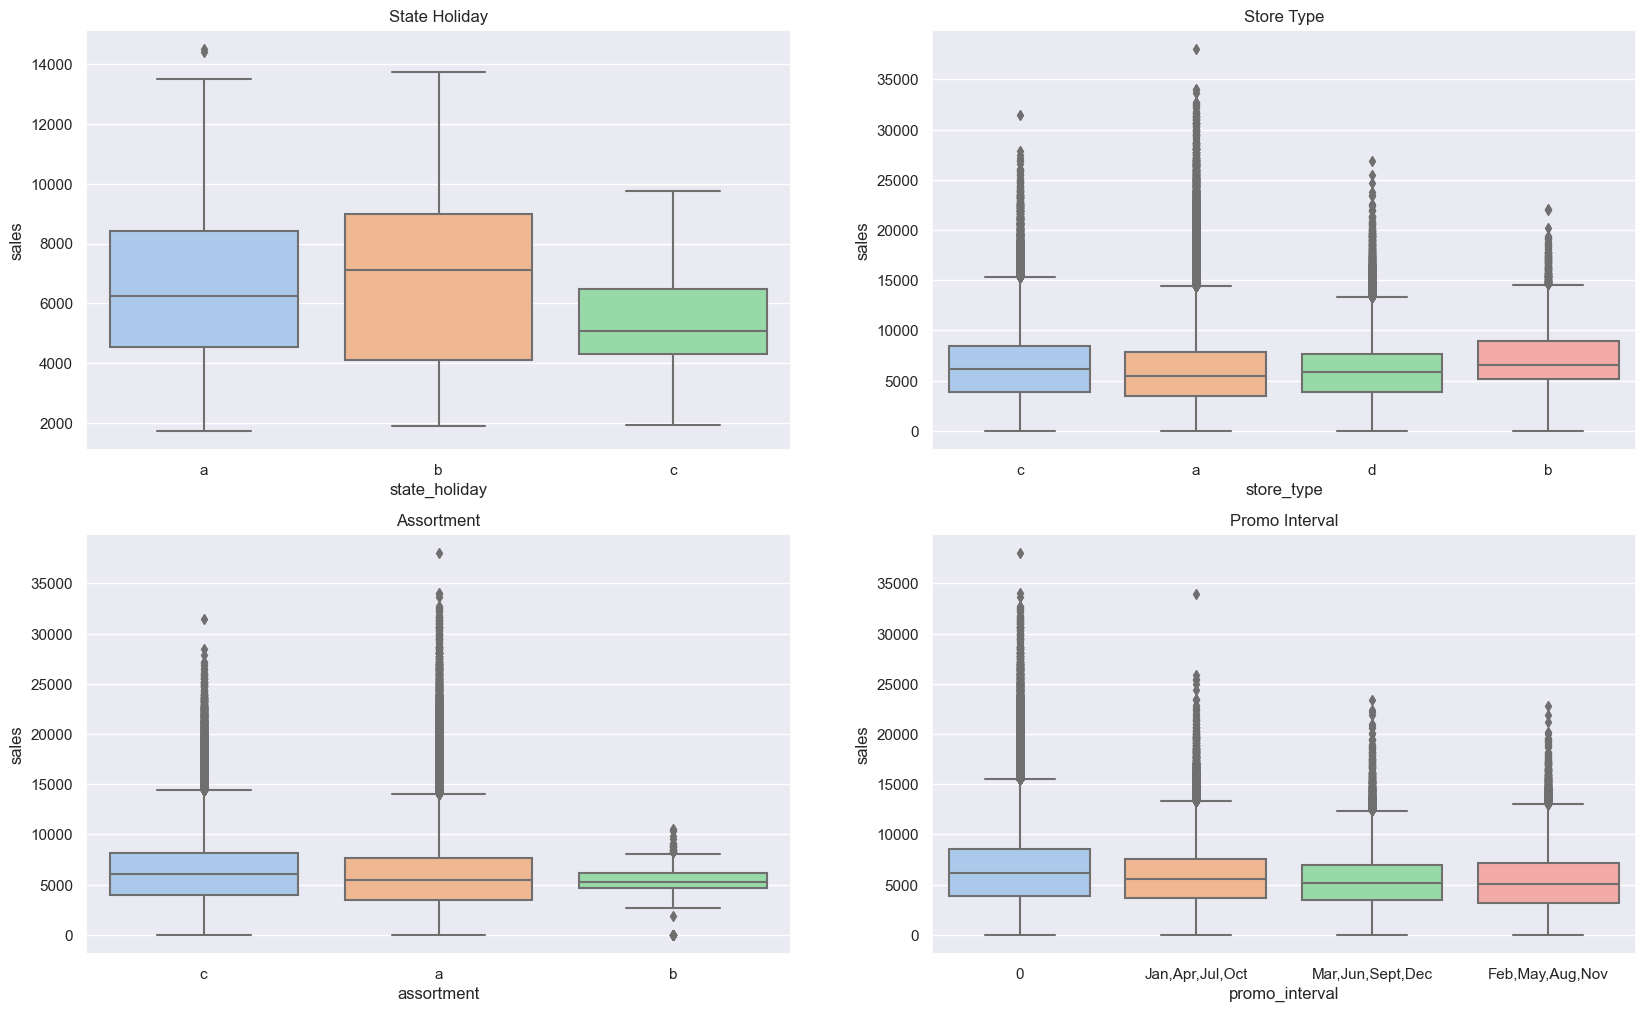

In [24]:
# Set figure size
plt.figure(figsize=(20, 12))

# Filters
aux1 = df2.loc[((df2['sales'] > 0) & (df2['state_holiday'] != '0')), :]

# State Holiday
plt.subplot(2, 2, 1)
ax1 = sns.boxplot(x='state_holiday', y='sales', data=aux1)
ax1.set_title('State Holiday')

# Store Type
plt.subplot(2, 2, 2)
ax2 = sns.boxplot(x='store_type', y='sales', data=df2)
ax2.set_title('Store Type')

# Assortment
plt.subplot(2, 2, 3)
ax3 = sns.boxplot(x='assortment', y='sales', data=df2)
ax3.set_title('Assortment')

# Promo Interval
plt.subplot(2, 2, 4)
ax4 = sns.boxplot(x='promo_interval', y='sales', data=df2)
ax4.set_title('Promo Interval')

plt.show()

# 3. FEATURE ENGINEERING

In [25]:
df3 = df2.copy()

## 3.1 Hypothesis Mindmap

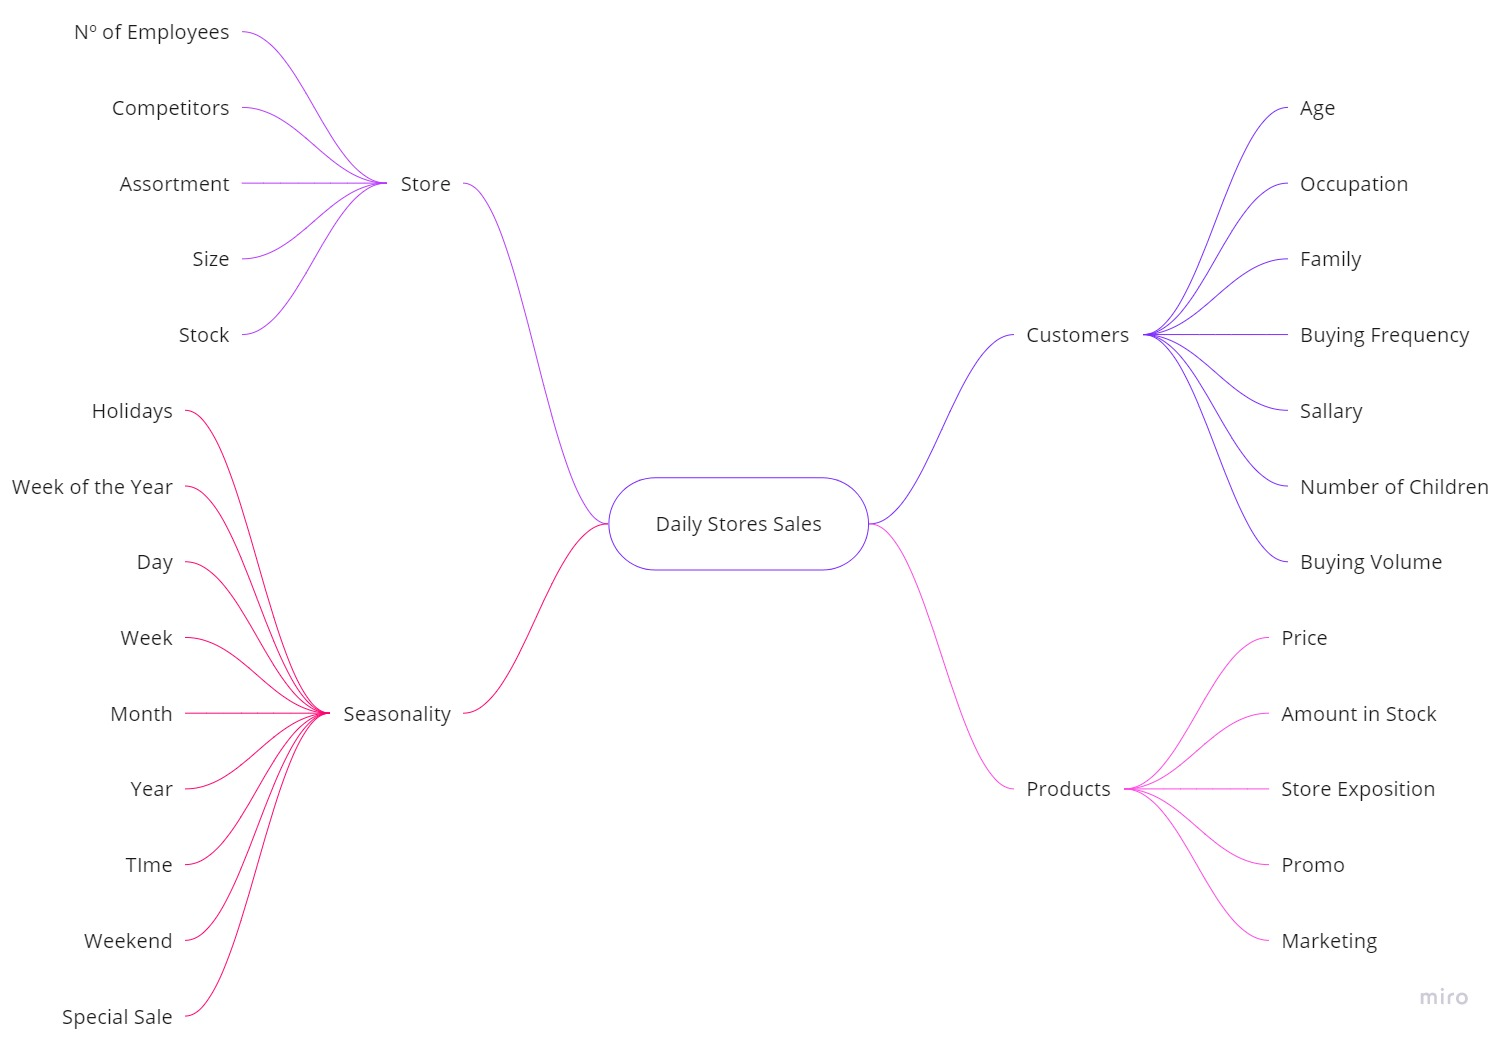

In [26]:
Image('img/mindmap.jpg')

## 3.2 Creating Hypothesis

### 3.2.1 Stores

1. Stores with more employees should sell more.
2. Stores with more stock capacity should sell more.
3. Larger stores should sell more.
4. Stores with a larger assortment should sell more.
5. Stores with closer competitors should sell less.
6. Stores with longer-term competitors should sell more.
7. Stores with more stock capacity should sell more.

### 3.2.2 Products

1. Stores that invest more in marketing should sell more.
2. Stores with more product exposure should sell more.
3. Stores with lower priced products should sell more.
5. Stores with more aggressive promotions (larger discounts) should sell more.
6. Stores with longer promotions should sell more.
7. Stores with more promotion days should sell more.
8. Stores with more consecutive promotions should sell more.

### 3.2.3 Seasonality

1. Stores open during the Christmas holiday should sell more.
2. Stores should sell more over the years.
3. Stores should sell more in the second half of the year.
4. Stores should sell more after the 10th of each month.
5. Stores should sell less on weekends.
6. Stores should sell less during school holidays.days.

## 3.3 Prioritized Hypothesis

1. Stores with a larger assortment should sell more.
2. Stores with closer competitors should sell less.
3. Stores with longer-term competitors should sell more.
4. Stores with longer promotions should sell more.
5. Stores with more promotion days should sell more.
6. Stores with more consecutive promotions should sell more.
7. Stores open during the Christmas holiday should sell more.
8. Stores should sell more over the years.
9. Stores should sell more in the second half of the year.
10. Stores should sell more after the 10th day of each month.
11. Stores should sell less on weekends.
12. Stores should sell less during school holidays.

## 3.4 Feature Engineering

In [27]:
# apply feature engineering
df3 = feature_engineering(df3)

# 4. FEATURE FILTERING

In [28]:
df4 = df3.copy()

## 4.1 Columns Description

- **store** - a unique Id for each store
- **day_of_week** - The ordinal day of week
- **date** - The date of the register (YYYY-MM-DD)
- **sales** - the turnover for any given day (this is what you are predicting)
- **customers** - the number of customers on a given day
- **open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **promo** - indicates whether a store is running a promo on that dayPromo
- **state_holiday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays.  Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **school_holiday** - indicates if the (Store, Date) was affected by the closure of public schools
- **store_type** - differentiates between 4 different store models: a, b, c, d
- **assorment** - describes an assortment level: a = basic, b = extra, c = extended
- **competition_distance** - distance in meters to the nearest competitor store
- **competition_open_since_month** - The number of the month in which since there's a competition running for that store
- **competition_open_since_year** - The number of the year in which since there's a competition running for that store
- **promo2** - Promo2 is a continuing and consecutive promotion for some stores:  0 = store is not participating, 1 = store is participating
- **promo2_since_week** - The number of the week of the year since the promo2 is running
- **promo2_since_year** - The number of the year since promo2 is running
- **promo_interval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store.
- **month_map** - The month name of the date
- **is_promo** - Flags if whether the current month is in promo interval. When it is, we can interpretate that promo2 is active on that date
- **year, month, week, day** - The derivated time granularity of each date**
- **year_week**- The week of the year and the year
- **competition_since_date** - The date of since when there's a competition (YYYY-MM-DD)
- **competition_number_month** - The number of months of since there's a near competitor to that store
- **promo_since** - The date of since there's a second promo on that store
- **promo_number_week** - The number of weeks since there's a second promo on that store


## 4.2 Rows Filtering

In [29]:
# Rows before filtering
len(df4)

273952

In [30]:
conditions = (df4['open'] != 0) & (df4['sales'] > 0)
df4 = df4[conditions].reset_index(drop=True)

# Rows after filtering
len(df4)

227152

## 4.3 Columns Selection

In [31]:
cols = ['customers', 'open', 'month_map', 'promo_interval']
df4.drop(columns=cols, axis=1, inplace=True)

In [32]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,week,day,year_week,competition_since_date,competition_number_months,promo_since,promo_number_weeks
0,4,5,2015-07-31,13995,1,no_holiday,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
1,5,5,2015-07-31,4822,1,no_holiday,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
2,12,5,2015-07-31,8959,1,no_holiday,1,a,extended,1070.0,...,1,2015,7,31,31,2015-30,2015-07-01,1,2010-03-22,279
3,18,5,2015-07-31,10071,1,no_holiday,1,d,extended,13840.0,...,1,2015,7,31,31,2015-30,2010-06-01,62,2012-03-26,174
4,19,5,2015-07-31,8234,1,no_holiday,1,a,extended,3240.0,...,0,2015,7,31,31,2015-30,2015-07-01,1,2011-05-23,218


# 5. EXPLORATORY DATA ANALYSIS (EDA)

In [33]:
df5 = df4.copy()

## 5.1 Univariate Analysis

In [34]:
# sales mean
np.mean(df5['sales'])

6991.087897090934

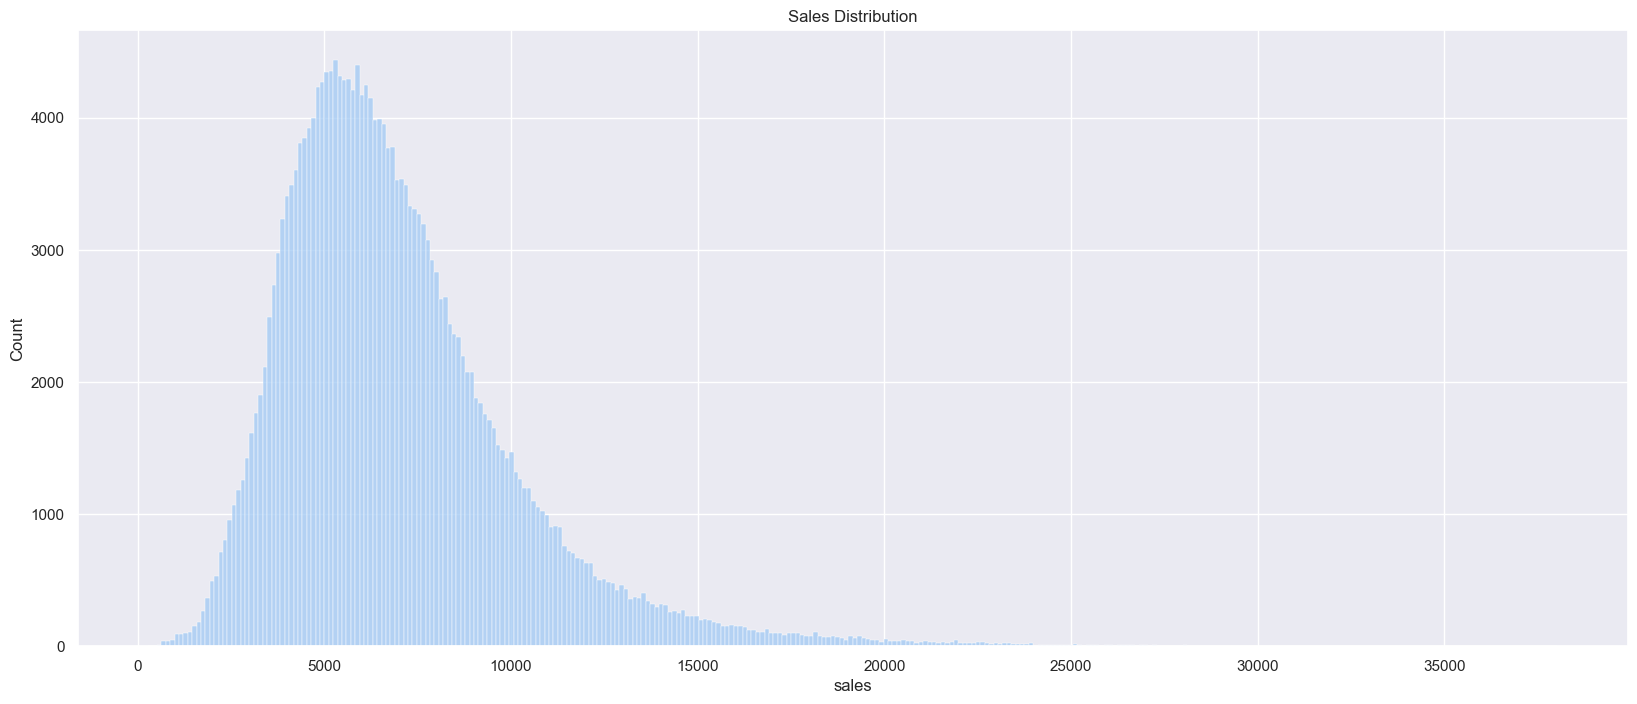

In [35]:
# Plot sales distribution
ax1 = sns.histplot(df5['sales'], legend=True)
ax1.set_title('Sales Distribution')
plt.show()

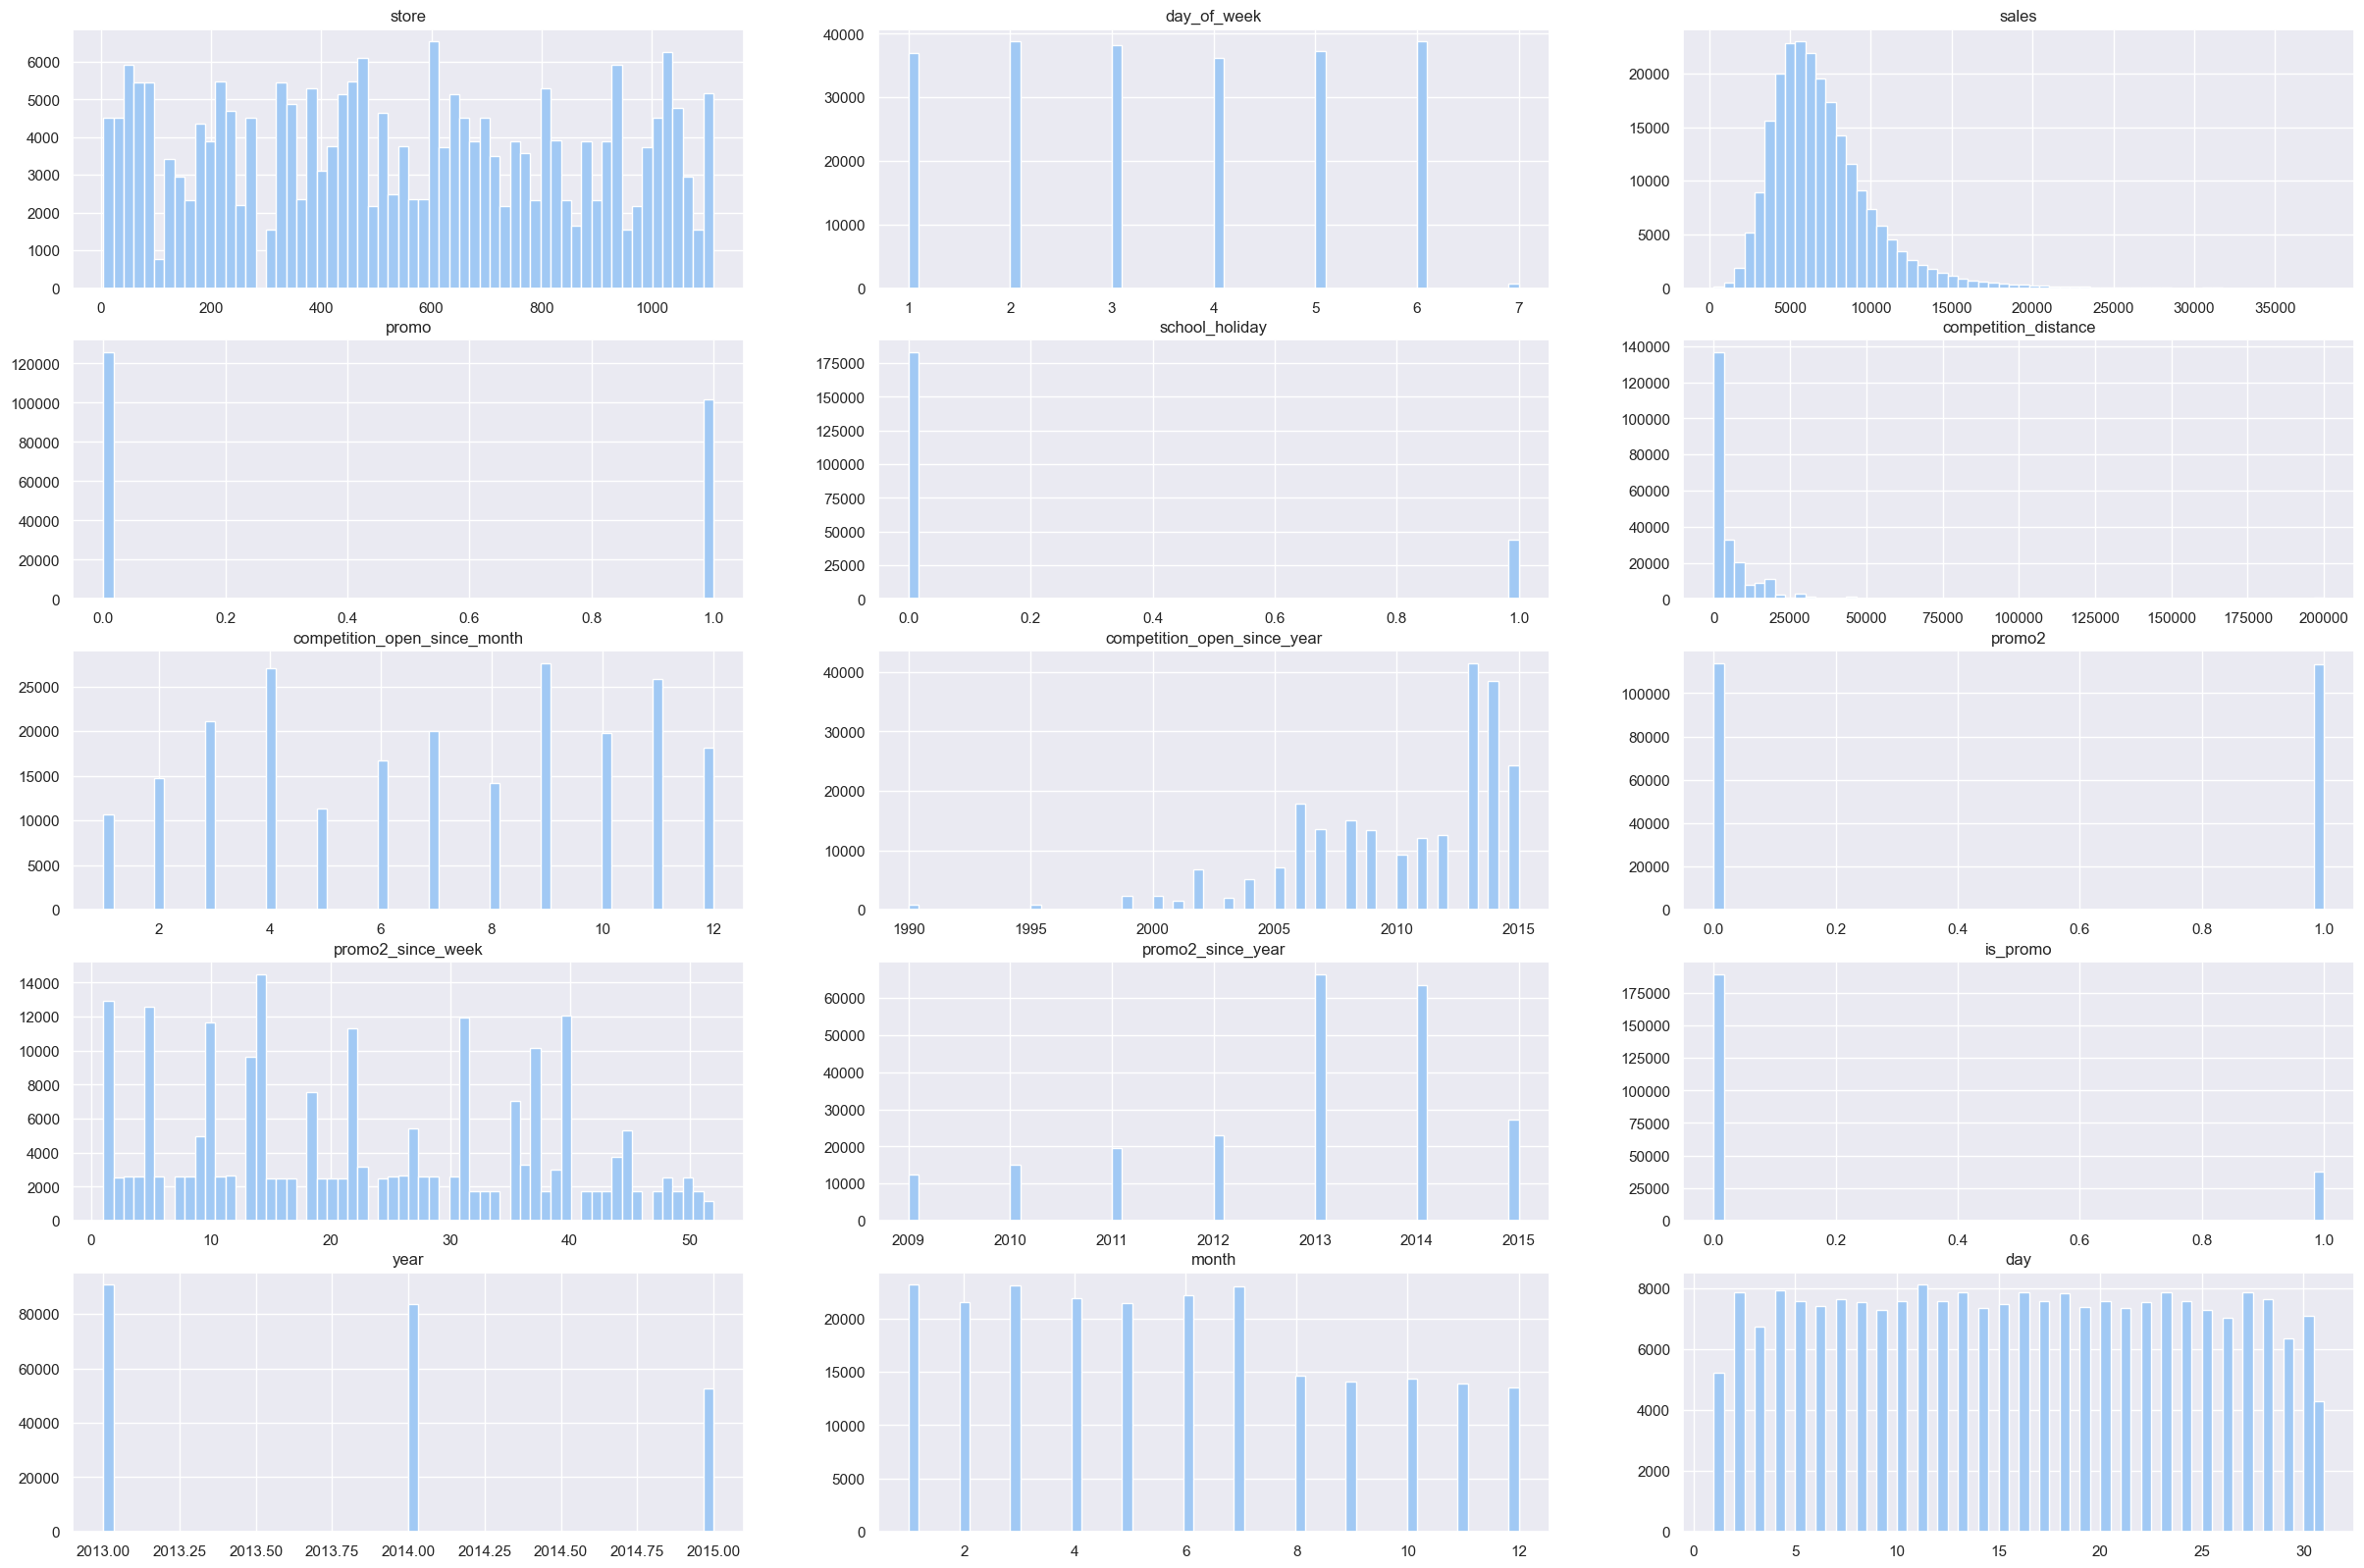

In [36]:
# Plot numerical attributes
num_att = df5.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(30, 24))

cols = num_att.columns.to_list()

for i in range(0, len(cols)):
    ax = plt.subplot(6, 3, i+1)
    ax.set_title(cols[i])

    num_att[cols[i]].hist(bins=60)

plt.show()

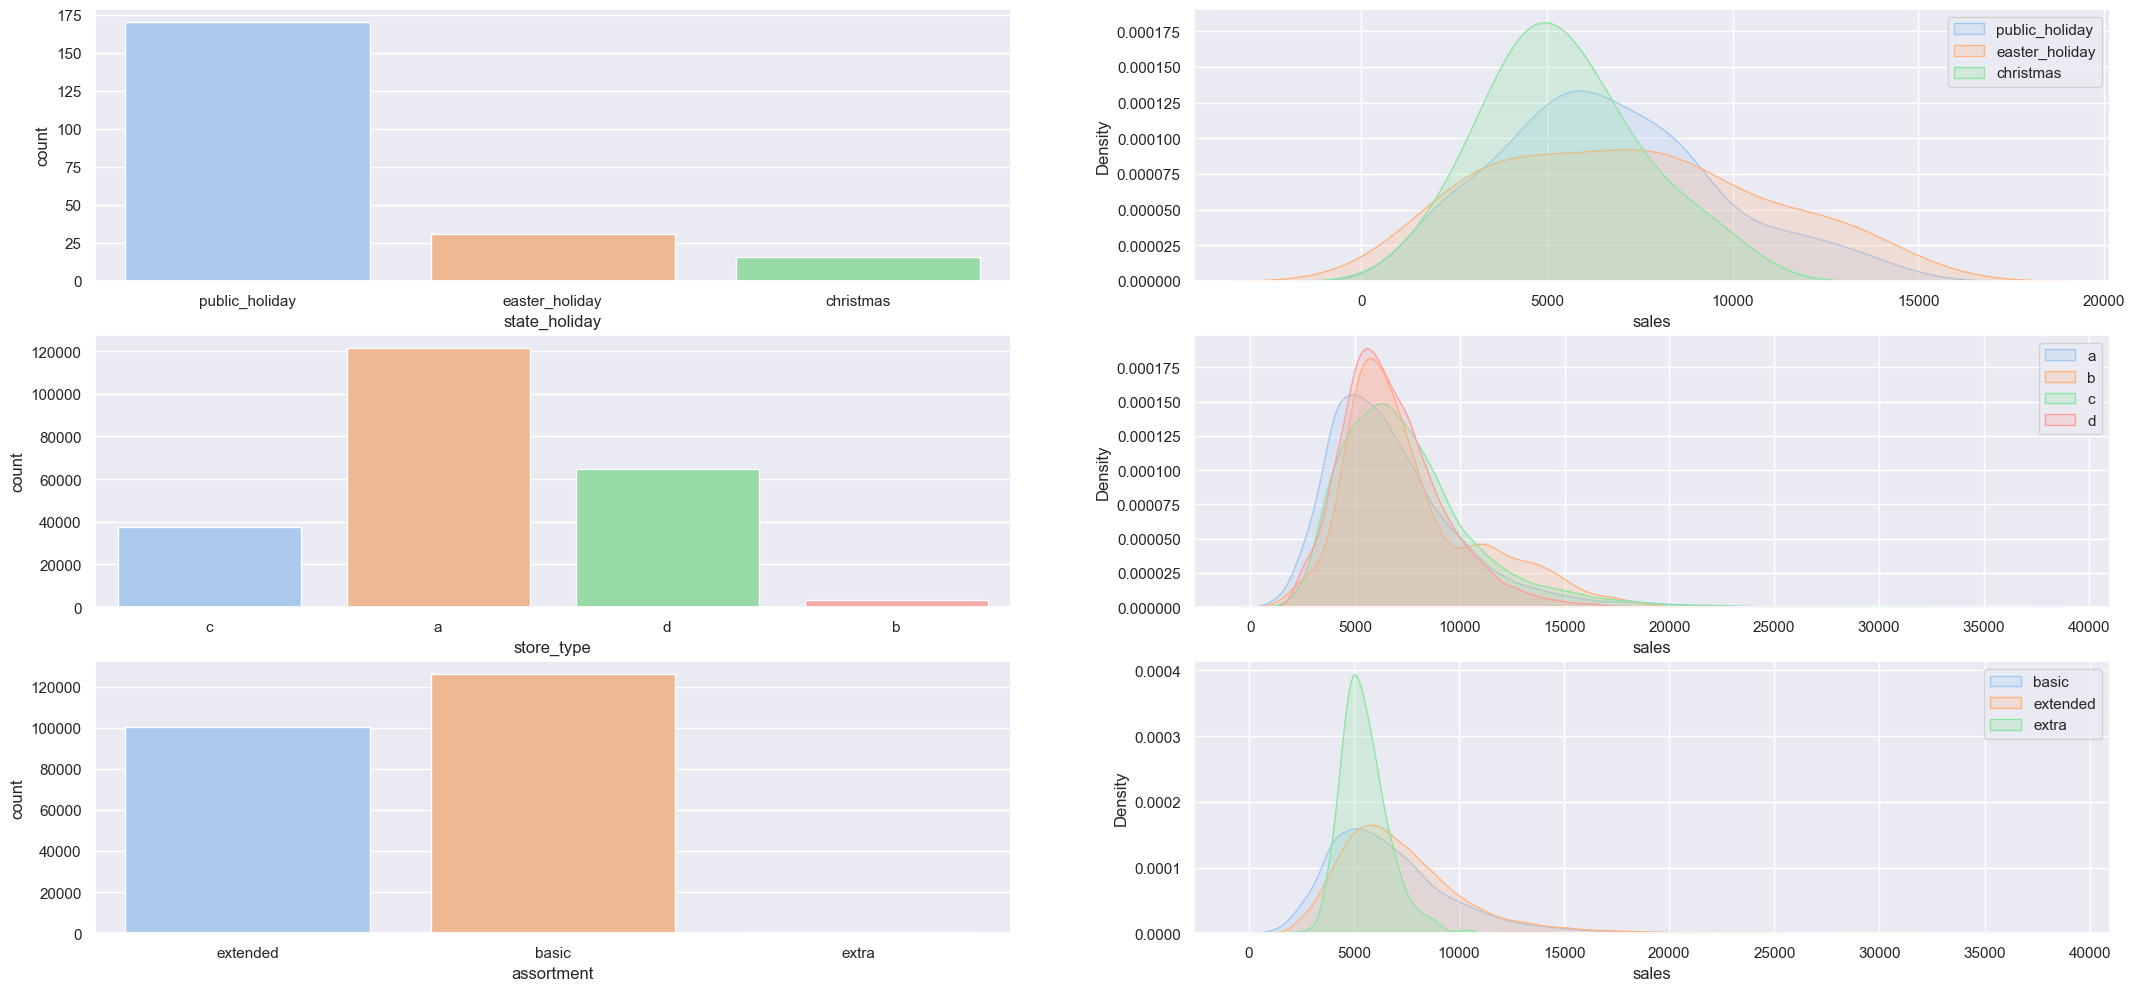

In [37]:
# Plot categorical attibutes vs sales
plt.figure(figsize=(26, 12))

# State holiday
a = df5[df5['state_holiday'] != 'no_holiday']

plt.subplot(3, 2, 1)
sns.countplot(x=a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df5[df5['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df5[df5['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df5[df5['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.legend(labels=['public_holiday', 'easter_holiday', 'christmas'])

# Store type
plt.subplot(3, 2, 3)
sns.countplot(x = df5['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df5[df5['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df5[df5['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df5[df5['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df5[df5['store_type'] == 'd']['sales'], label='d', fill=True)
plt.legend(labels=['a', 'b', 'c', 'd'])

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(x= df5['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df5[df5['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df5[df5['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df5[df5['assortment'] == 'extra']['sales'], label='extra', fill=True)
plt.legend(labels=['basic', 'extended', 'extra']);

## 5.2 Bivariate Analysis

### H1 - Stores with a larger assortment should sell more 
**(FALSE)** - Basic assortment represent as bigger amount of sales. Throughout time, the behavior kept very stable

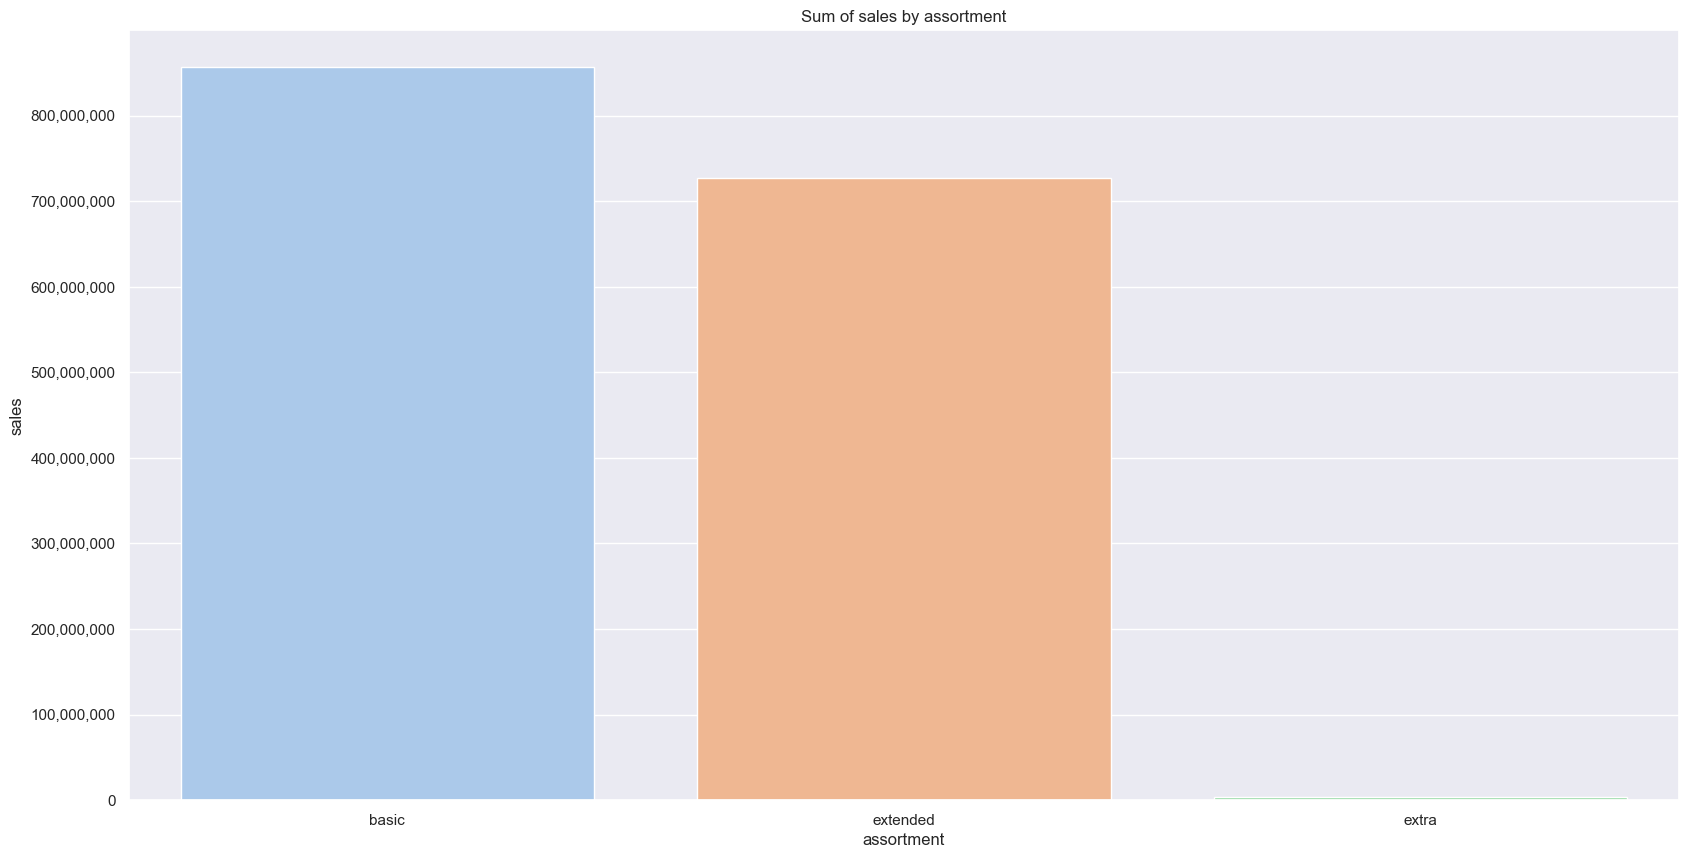

In [38]:
plt.figure(figsize=(20, 10))

# bar plot of sales by assortment
aux1 = df5[['assortment', 'sales']].groupby('assortment').sum().reset_index()

ax1 = sns.barplot(data=aux1, x='assortment', y='sales')
ax1.set_title('Sum of sales by assortment')

plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

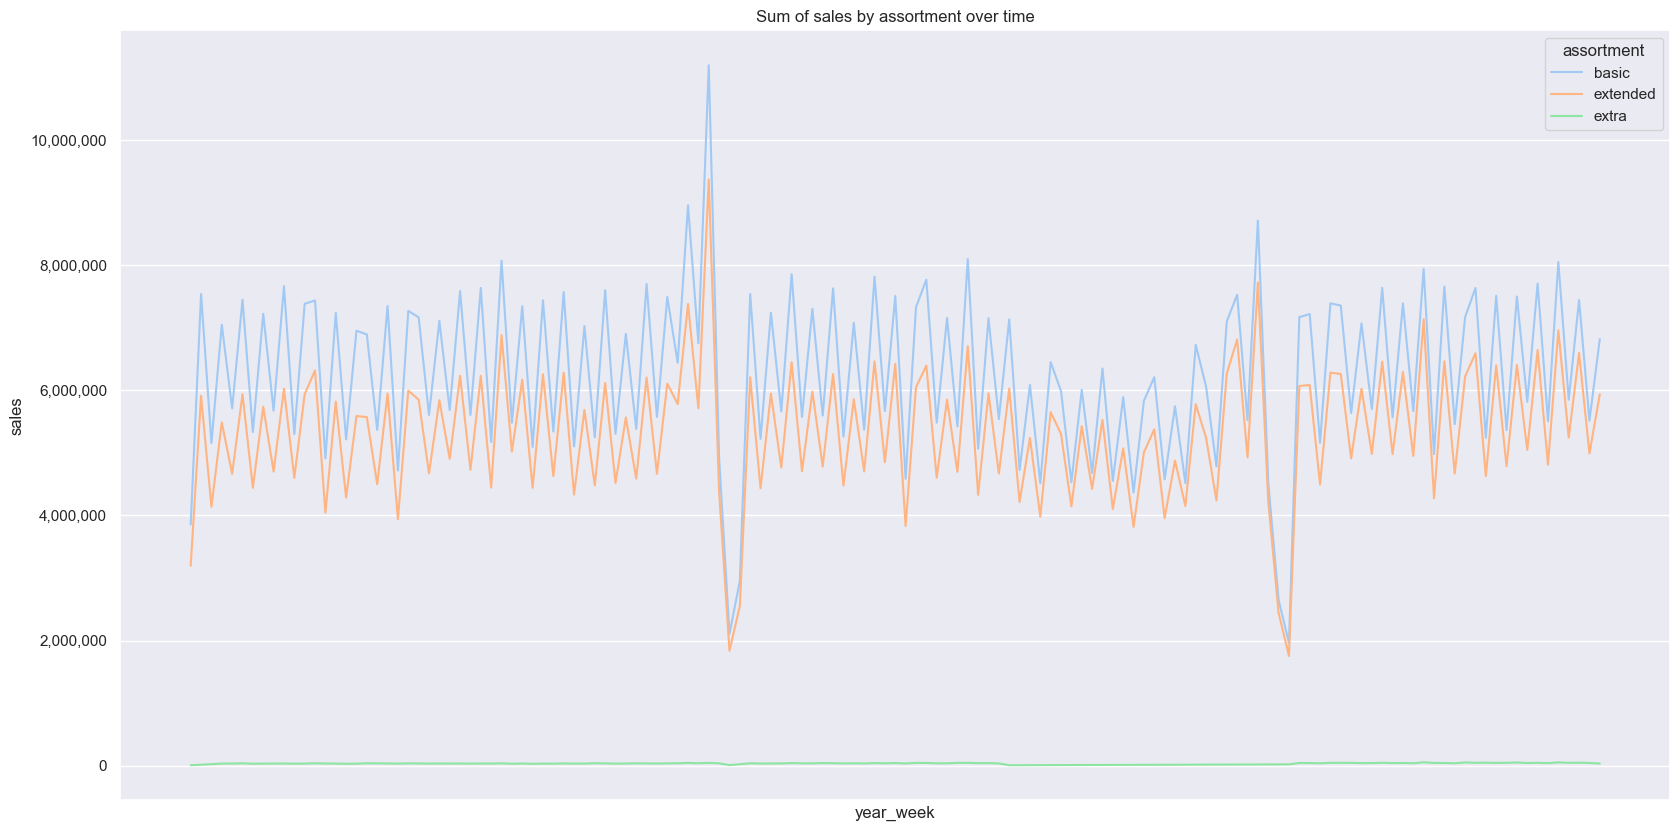

In [39]:
plt.figure(figsize=(20, 10))

# time series of sales by assortment over time
aux2 = df5[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()

ax2 = sns.lineplot(data=aux2, x='year_week', y='sales', hue='assortment')
ax2.set_title('Sum of sales by assortment over time')

plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks([])
plt.show()

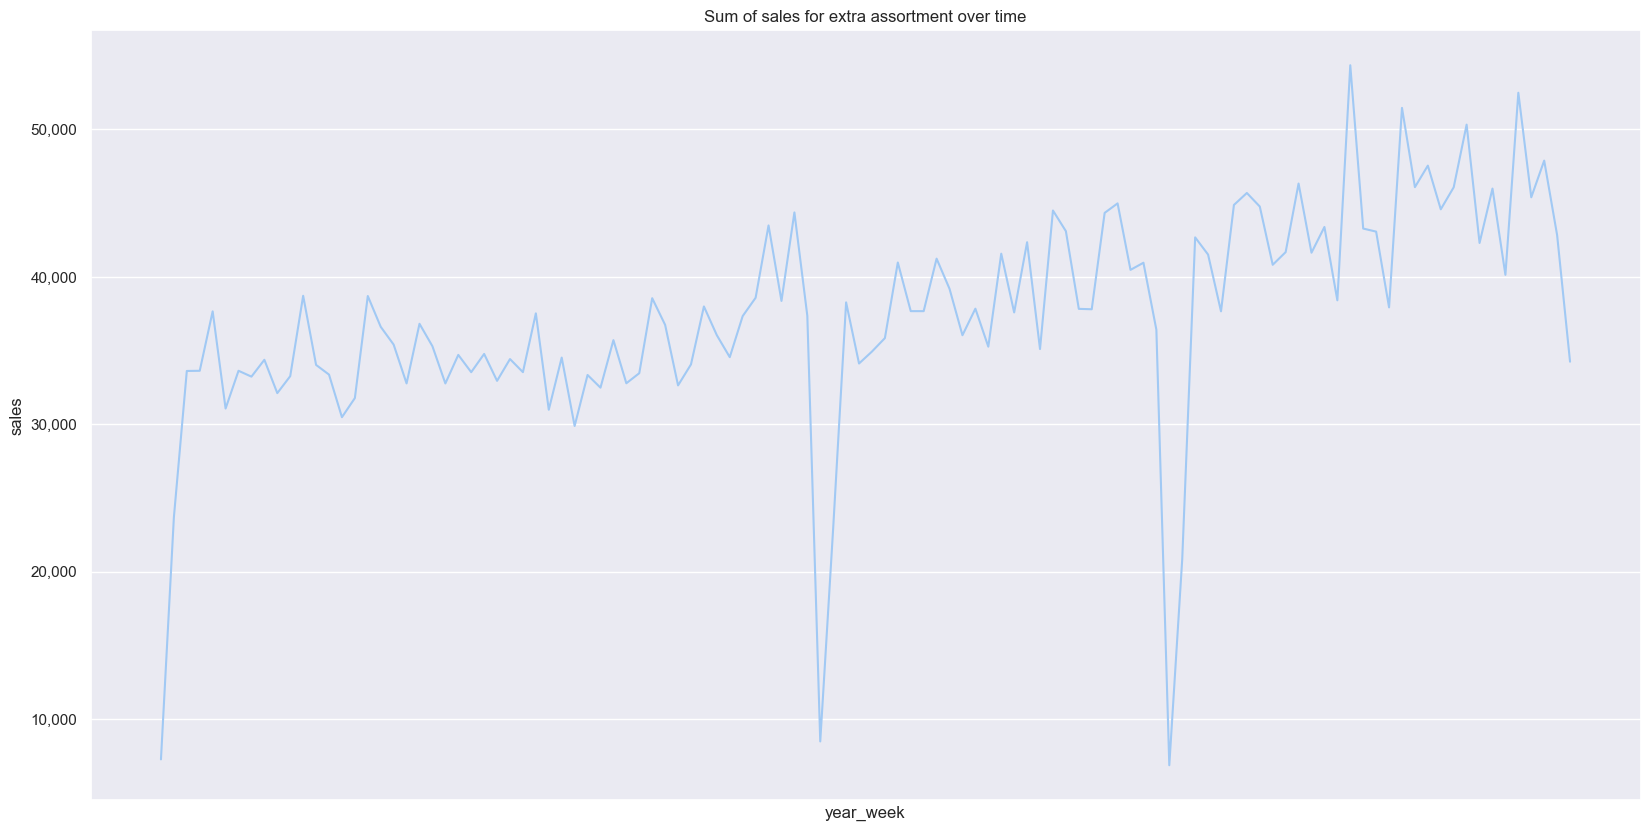

In [40]:
plt.figure(figsize=(20, 10))

# time series of sales by assortment over time
aux3 = df5.loc[df5['assortment'] == 'extra', :][['year_week', 'sales']].groupby(['year_week']).sum().reset_index()

ax3 = sns.lineplot(data=aux3, x='year_week', y='sales')
ax3.set_title('Sum of sales for extra assortment over time')

plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks([])
plt.show()

### H2. Stores with closer competitors should sell less 
**(FALSE)** - Stores with closer competitors sells more in volume if compared with stores with distant competitors.

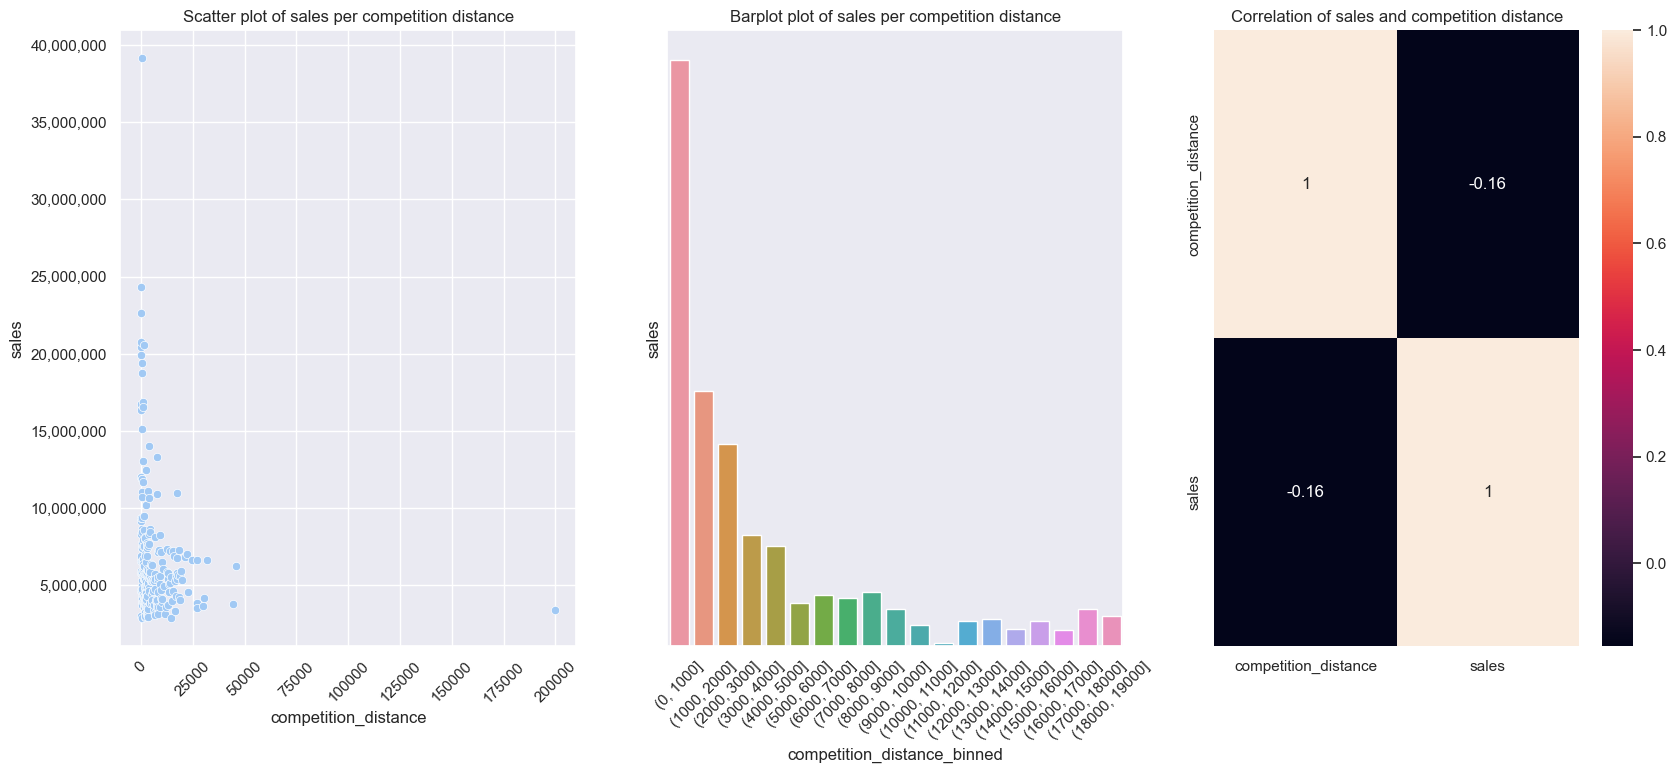

In [41]:
aux1 = df5[['sales', 'competition_distance']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
ax1 = sns.scatterplot(data=aux1, x='competition_distance', y='sales')
ax1.set_title('Scatter plot of sales per competition distance')
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], list(range(0, 20000, 1000)))
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
ax2 = sns.barplot(data=aux2, x='competition_distance_binned', y='sales')
ax2.set_title('Barplot plot of sales per competition distance')
plt.yticks([])
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
ax3 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax3.set_title('Correlation of sales and competition distance')

plt.show()

### H3. Stores with longer-term competitors should sell more. 
**(FALSE)** - As competition time increases, the sales volume decreases

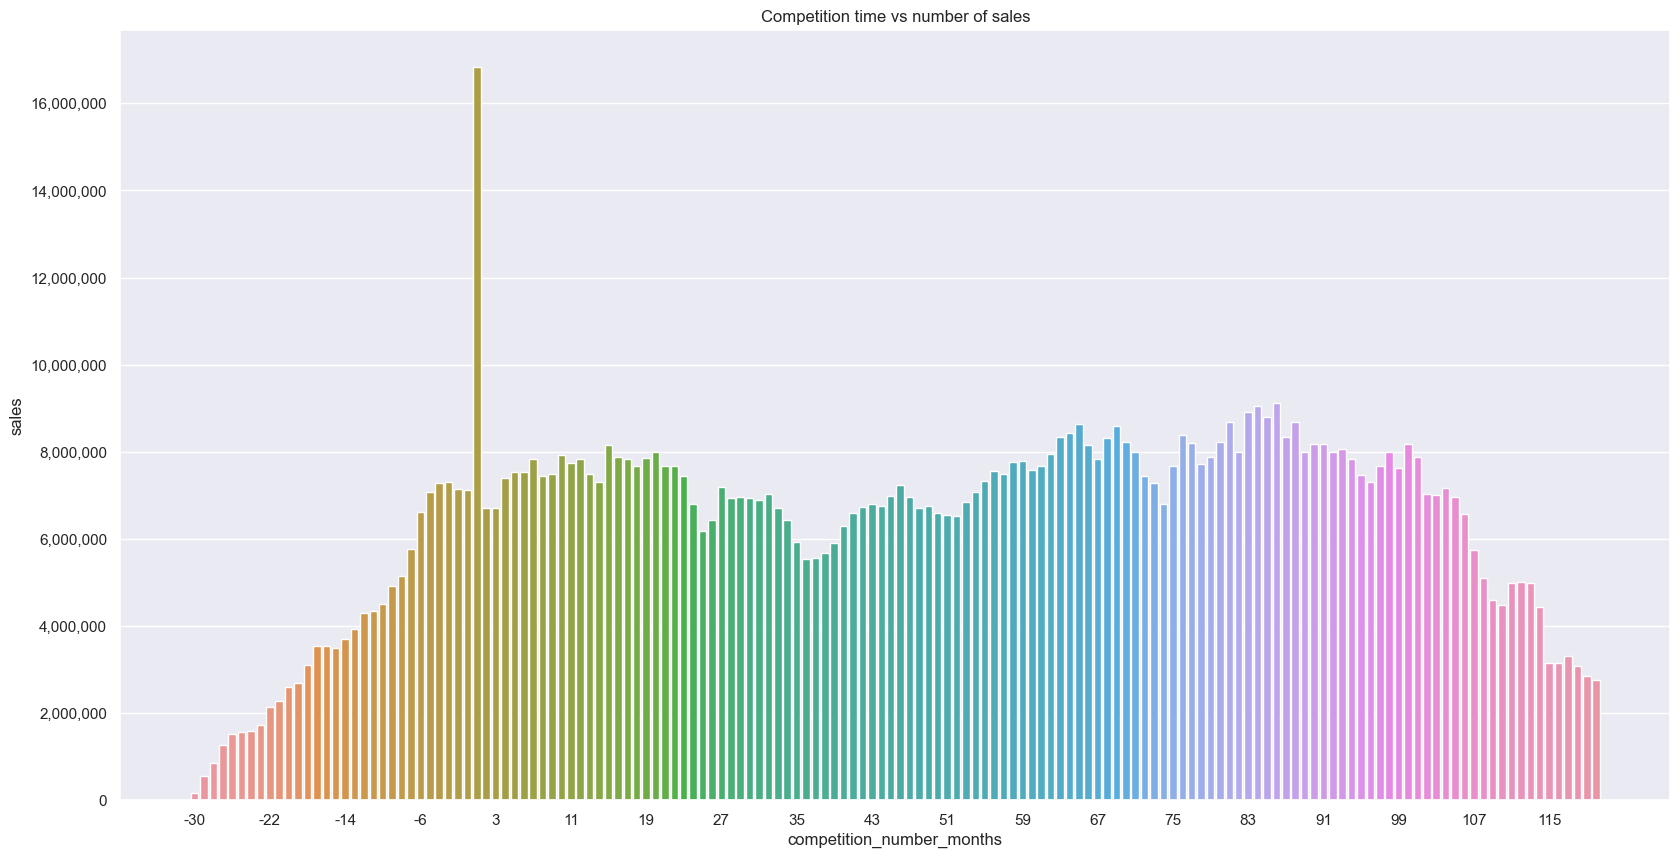

In [42]:
plt.figure(figsize=(20, 10))

min_competition = df5['competition_number_months'].min()
max_competition = 120

filter = (df4['competition_number_months'] >= min_competition) & (df5['competition_number_months'] <= max_competition) & (df5['competition_number_months'] != 0)
aux1 = df4.loc[filter, :][['competition_number_months', 'sales']].groupby('competition_number_months').sum().reset_index()
aux2 = df4[['competition_number_months', 'sales']].groupby('competition_number_months').sum().reset_index()

ax1 = sns.barplot(data=aux1, x='competition_number_months', y='sales')
ax1.set_title('Competition time vs number of sales')
ax1.locator_params(axis='x', nbins=20)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

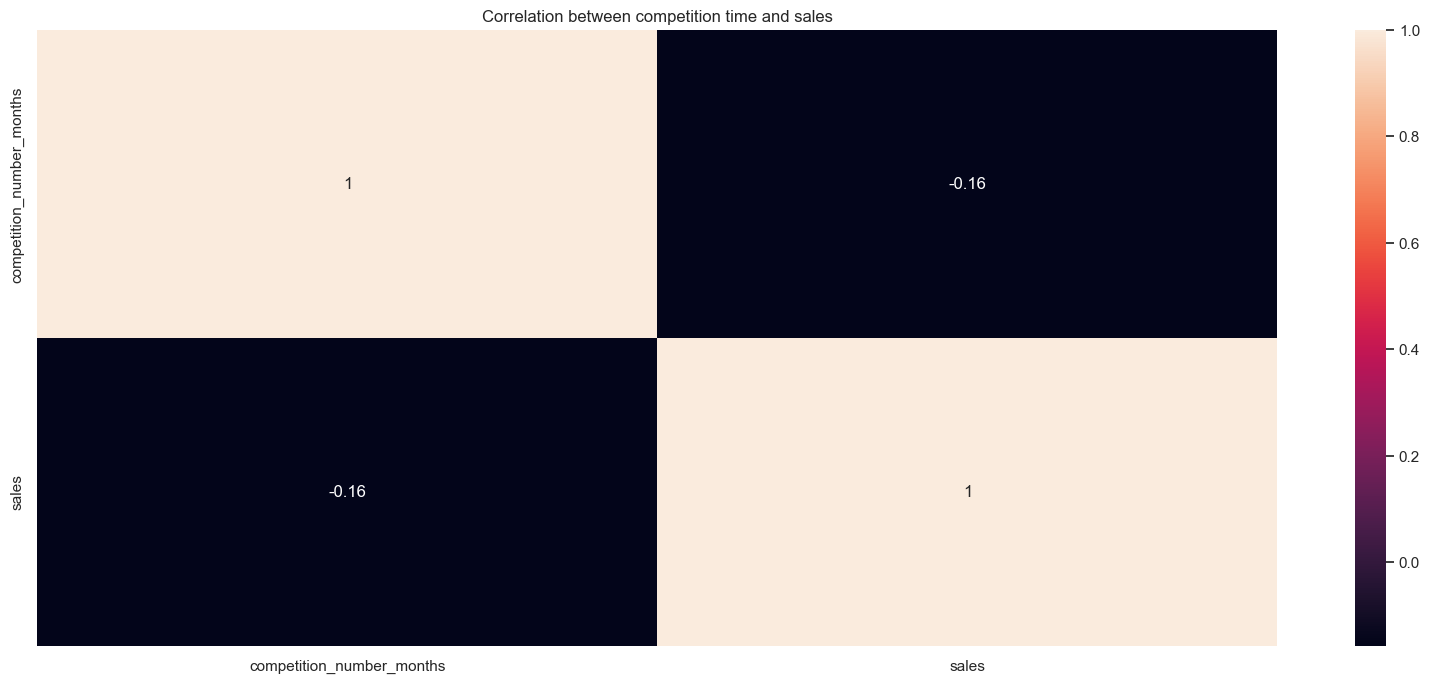

In [43]:
ax2 = sns.heatmap(aux2.corr(method='pearson'), annot=True)
ax2.set_title('Correlation between competition time and sales')
plt.show()

### H4. Stores with longer promotions should sell more 
**(FALSE)** - Store with extended promotions tend to less over time.

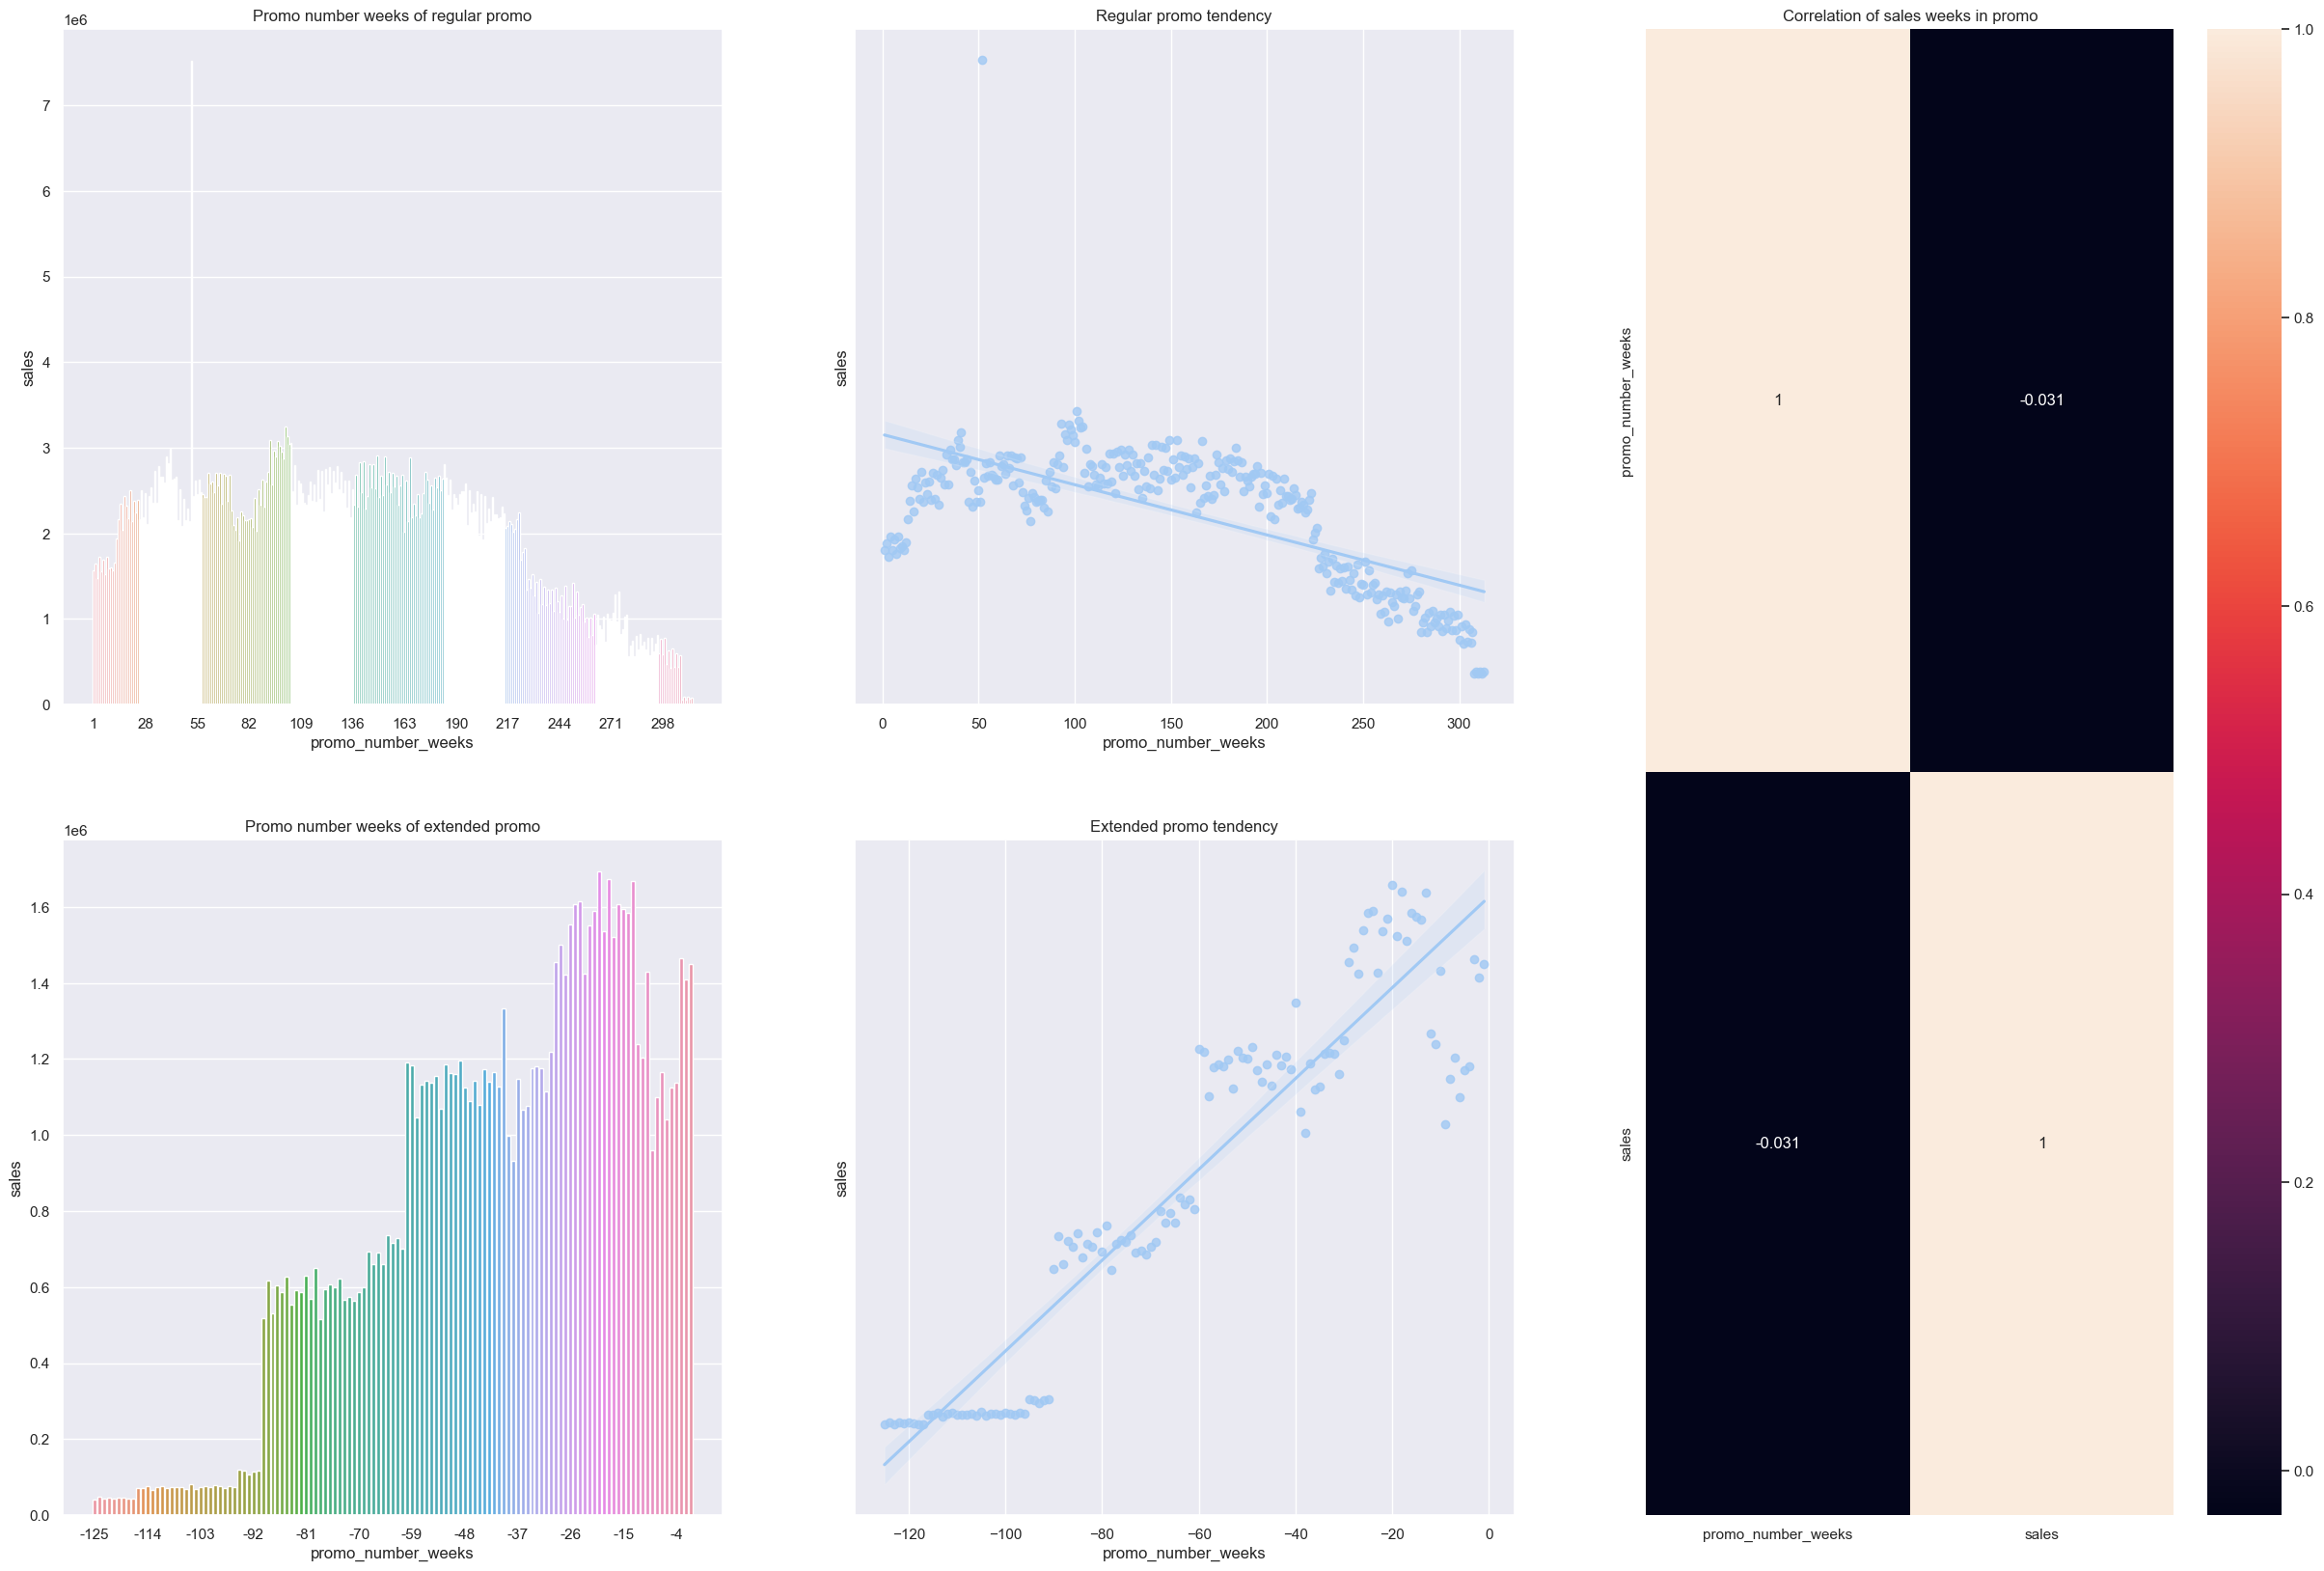

In [44]:
plt.figure(figsize=(30, 20))

aux1 = df5[['sales', 'promo_number_weeks']].groupby('promo_number_weeks').sum().reset_index()
aux3 = aux1[aux1['promo_number_weeks'] > 0] # extended (promo)
aux2 = aux1[aux1['promo_number_weeks'] < 0] # regular (promo2)

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
ax1 = sns.barplot(data=aux3, x='promo_number_weeks', y='sales')
ax1.set_title('Promo number weeks of regular promo')
ax1.locator_params(axis='x', nbins=12)

plt.subplot(grid[0, 1])
ax2 = sns.regplot(data=aux3, x='promo_number_weeks', y='sales')
ax2.set_title('Regular promo tendency')
plt.yticks([])

plt.subplot(grid[1, 0])
ax3 = sns.barplot(data=aux2, x='promo_number_weeks', y='sales')
ax3.set_title('Promo number weeks of extended promo')
ax3.locator_params(axis='x', nbins=12)

plt.subplot(grid[1, 1])
ax4 = sns.regplot(data=aux2, x='promo_number_weeks', y='sales')
ax4.set_title('Extended promo tendency')
plt.yticks([])

plt.subplot(grid[:, 2])
ax5 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax5.set_title('Correlation of sales weeks in promo')

plt.show()

### <s>H5. Stores with more promotion days should sell more</s>

### H6. Stores with more consecutive promotions should sell more 
(**FALSE**) - Stores with shorter promotions tend to sell more

In [45]:
aux1 = df5[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales', ascending=False)
aux1

,promo,promo2,sales
2,1,0,457471113
0,0,0,406732688
3,1,1,388011329
1,0,1,335824468


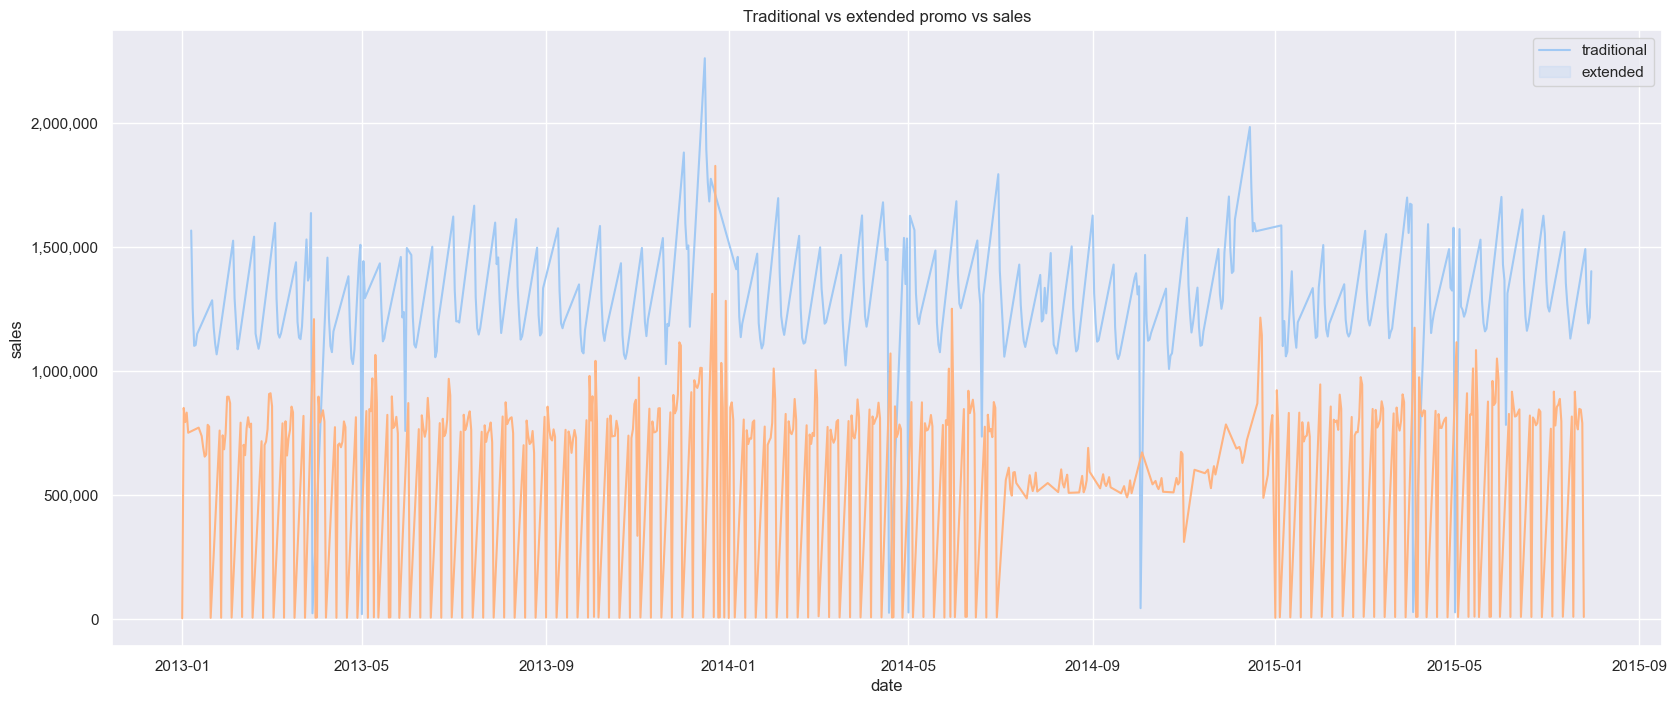

In [46]:
# traditional and extended
aux1 = df5[(df5['promo'] == 1) & (df5['promo2'] == 0)][['sales', 'date']].groupby('date').sum().reset_index()
ax = sns.lineplot(data=aux1, x='date', y='sales')

# traditional
aux2 = df4[(df5['promo'] == 0) & (df5['promo2'] == 1)][['sales', 'date']].groupby('date').sum().reset_index()
sns.lineplot(data = aux2, x='date', y='sales', ax=ax)

ax.legend(labels=['traditional', 'extended'])
ax.set_title('Traditional vs extended promo vs sales')
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

### H7. Stores open during the Christmas holiday should sell more 
**(FALSE)** - Christmas is the holiday with less sales.

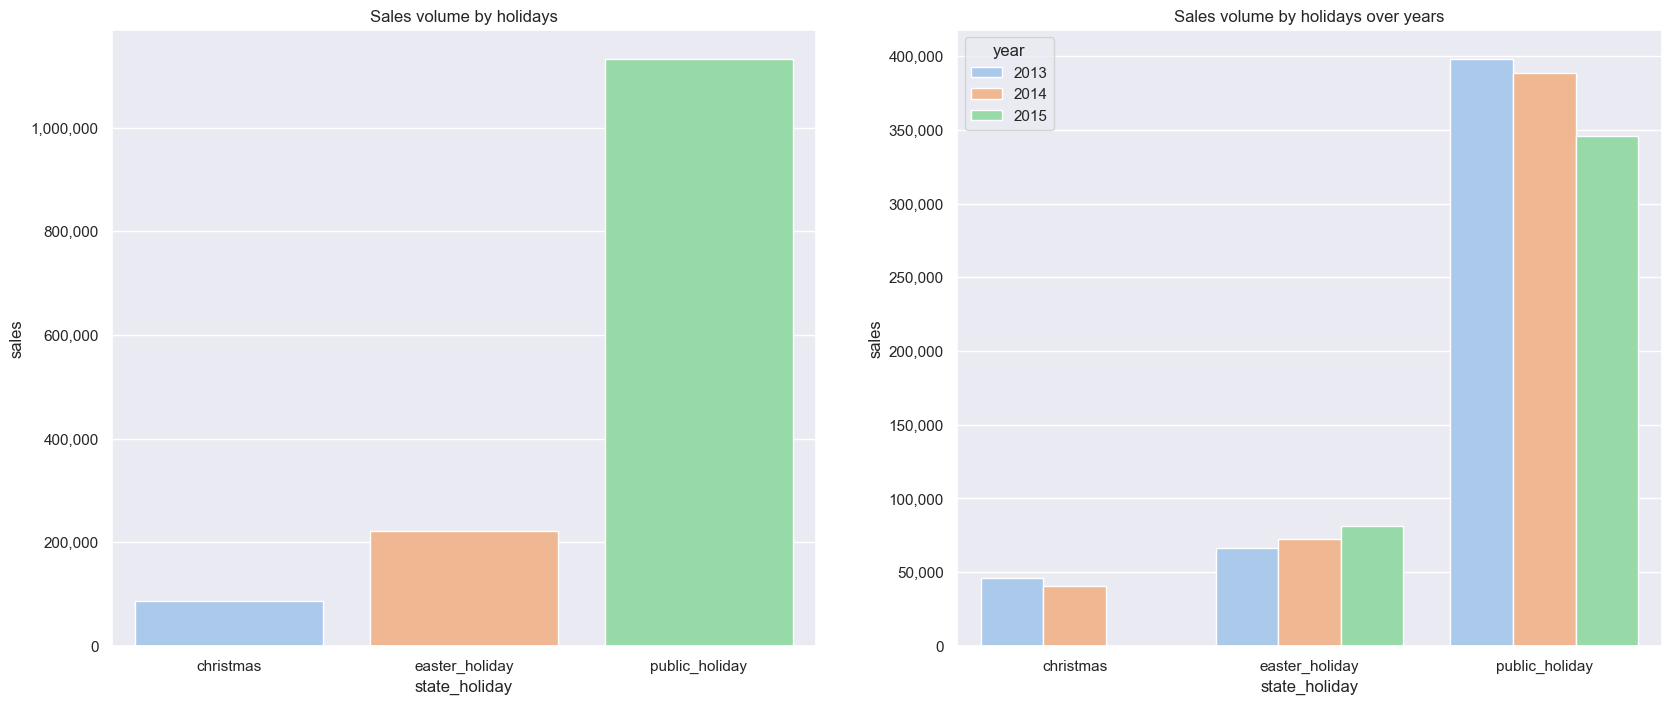

In [47]:
aux1 = df5[df5['state_holiday'] != 'no_holiday'][['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
aux2 = df5[df5['state_holiday'] != 'no_holiday'][['state_holiday', 'year', 'sales']].groupby(['state_holiday', 'year']).sum().reset_index()

plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=aux1, x='state_holiday', y='sales')
ax1.set_title('Sales volume by holidays')
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=aux2, x='state_holiday', y='sales', hue='year')
ax2.set_title('Sales volume by holidays over years')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

### H8. Stores should sell more over the years 
**(TRUE)** - The average sales increases over years, and also, if we compare the closed period of all the three years.

We have data of three years (2013, 2014 and 2015), but 2015 we had data until jul 31th. Being so, we will analyze from two points of view. We will look at the mean sales volume, and also will look to the sales data ultil jul 31th of the other years.

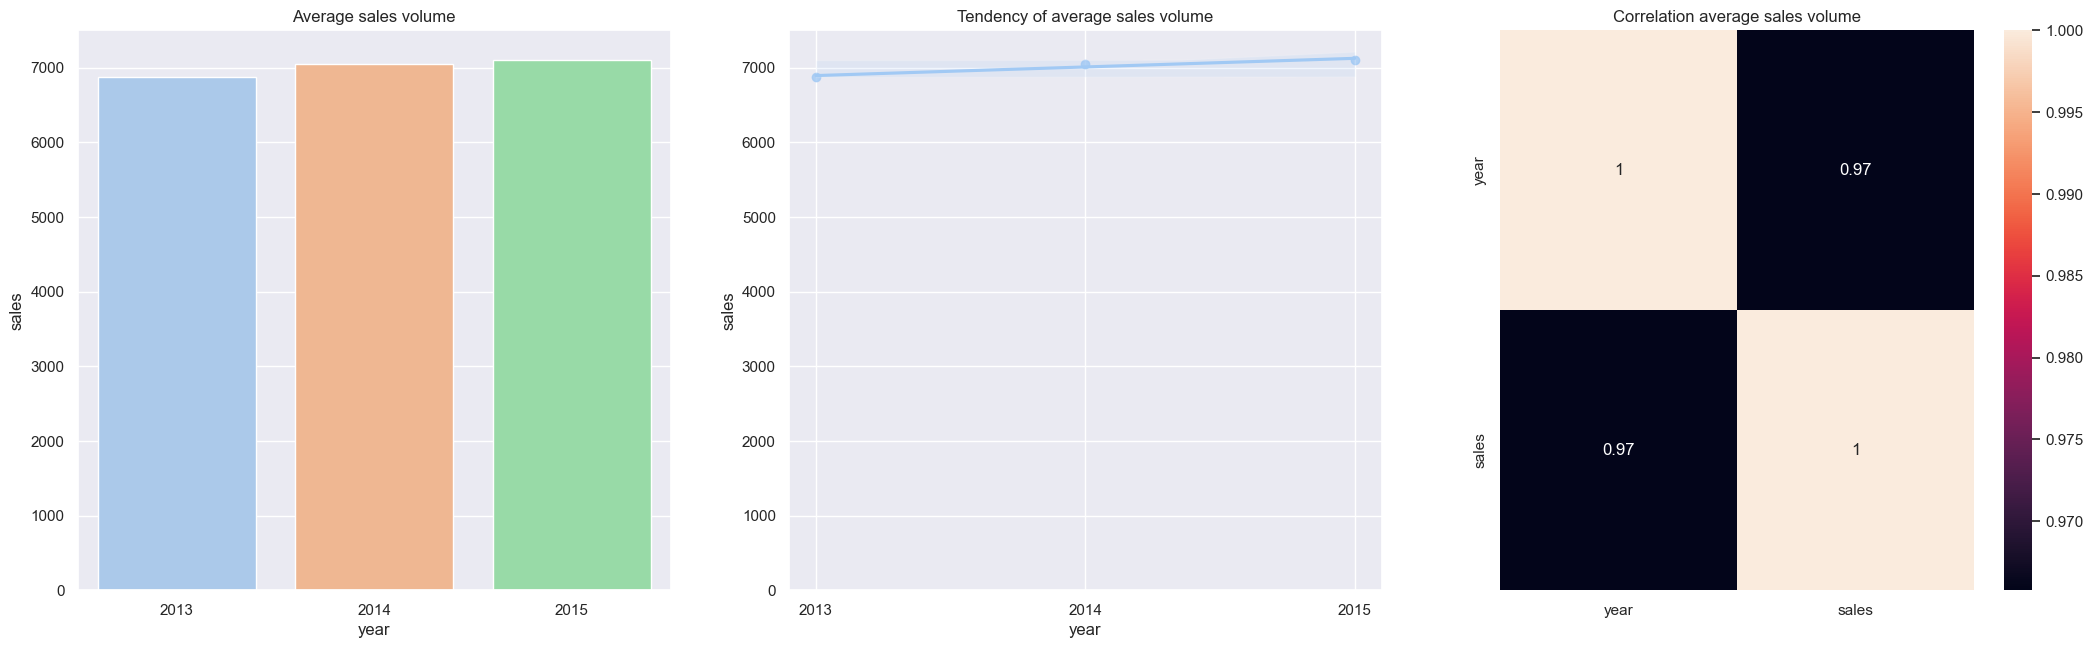

In [48]:
plt.figure(figsize=(26, 16))
aux1 = df5[['year', 'sales']].groupby('year').mean().reset_index()

plt.subplot(2, 3, 1)
ax1 = sns.barplot(data=aux1, x='year', y='sales')
ax1.set_title('Average sales volume')
plt.ylim([0, 7500])

plt.subplot(2, 3, 2)
ax2 = sns.regplot(data=aux1, x='year', y='sales')
ax2.set_title('Tendency of average sales volume')
plt.xticks([2013, 2014, 2015])
plt.ylim([0, 7500])

plt.subplot(2, 3, 3)
ax3 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax3.set_title('Correlation average sales volume')

plt.show()

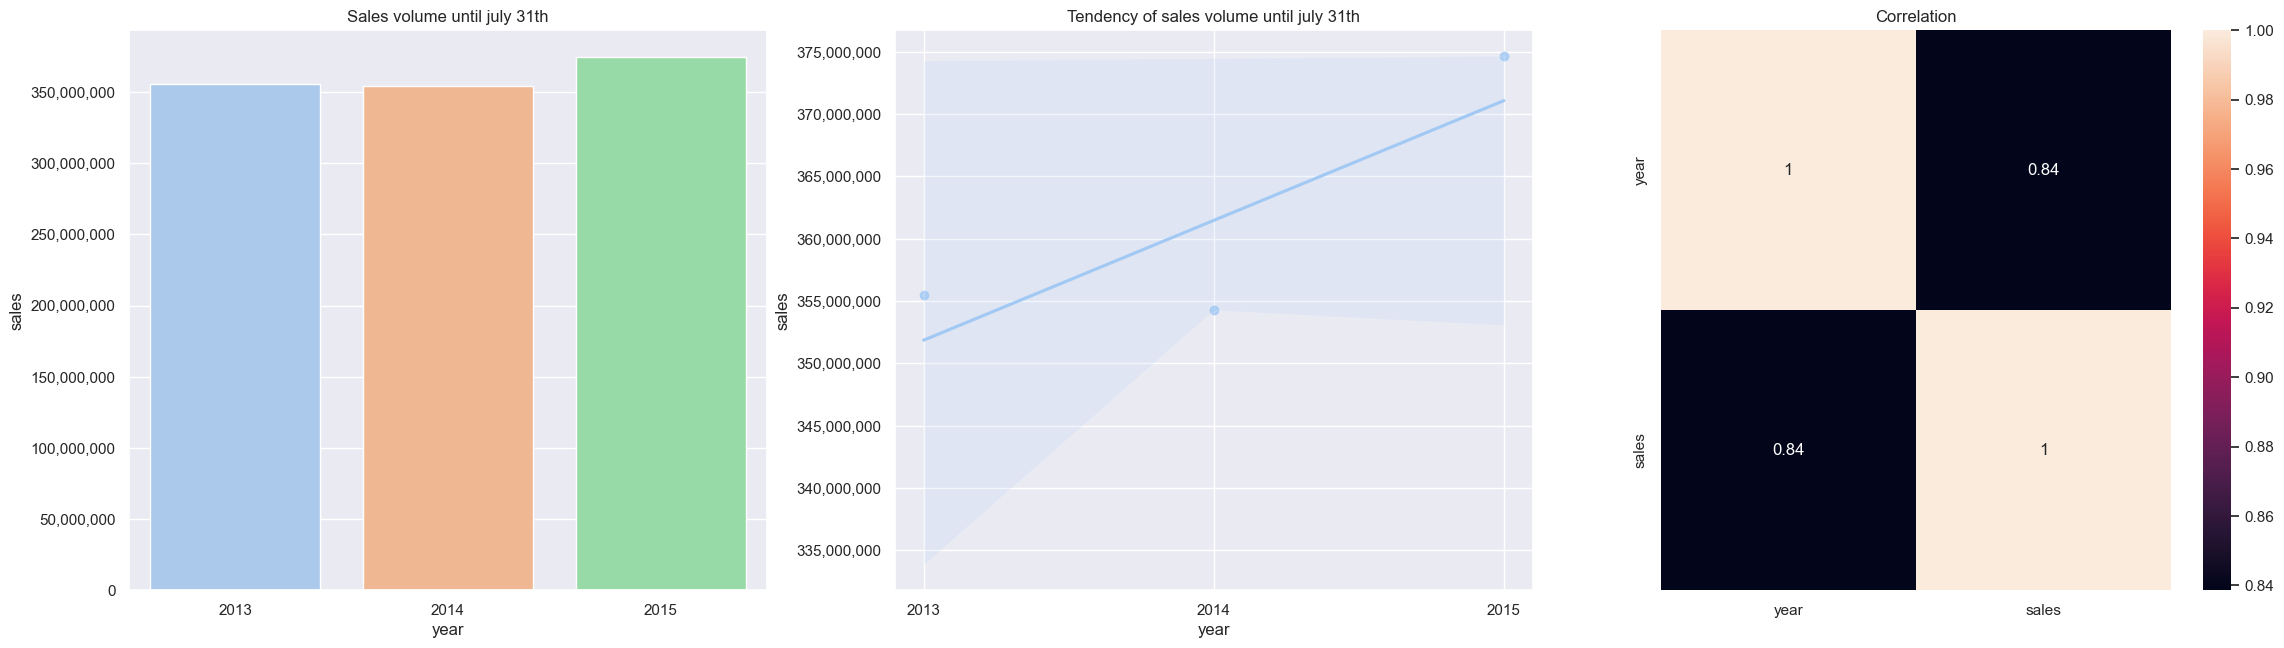

In [49]:
plt.figure(figsize=(28, 16))

f2013 = (df5['date'] >= "2013-01-01") & (df4['date'] <= "2013-07-31")
f2014 = (df5['date'] >= "2014-01-01") & (df4['date'] <= "2014-07-31")
f2015 = (df5['date'] >= "2015-01-01") & (df4['date'] <= "2015-07-31")

aux2 = df5[f2013 | f2014 | f2015][['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(2, 3, 1)
ax1 = sns.barplot(data=aux2, x='year', y='sales')
ax1.set_title('Sales volume until july 31th')
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(2, 3, 2)
ax2 = sns.regplot(data=aux2, x='year', y='sales')
ax2.set_title('Tendency of sales volume until july 31th')
plt.xticks([2013, 2014, 2015])
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(2, 3, 3)
ax3 = sns.heatmap(aux2.corr(method='pearson'), annot=True)
ax3.set_title('Correlation')

plt.show()

### H9. Stores should sell more in the second half of the year
**(TRUE)** - This is true, but only because december have a great amount of sales, which pulls the tendency up throughout the year

It is impossible to compare 2015. So, we will consider only 2013 and 2014.

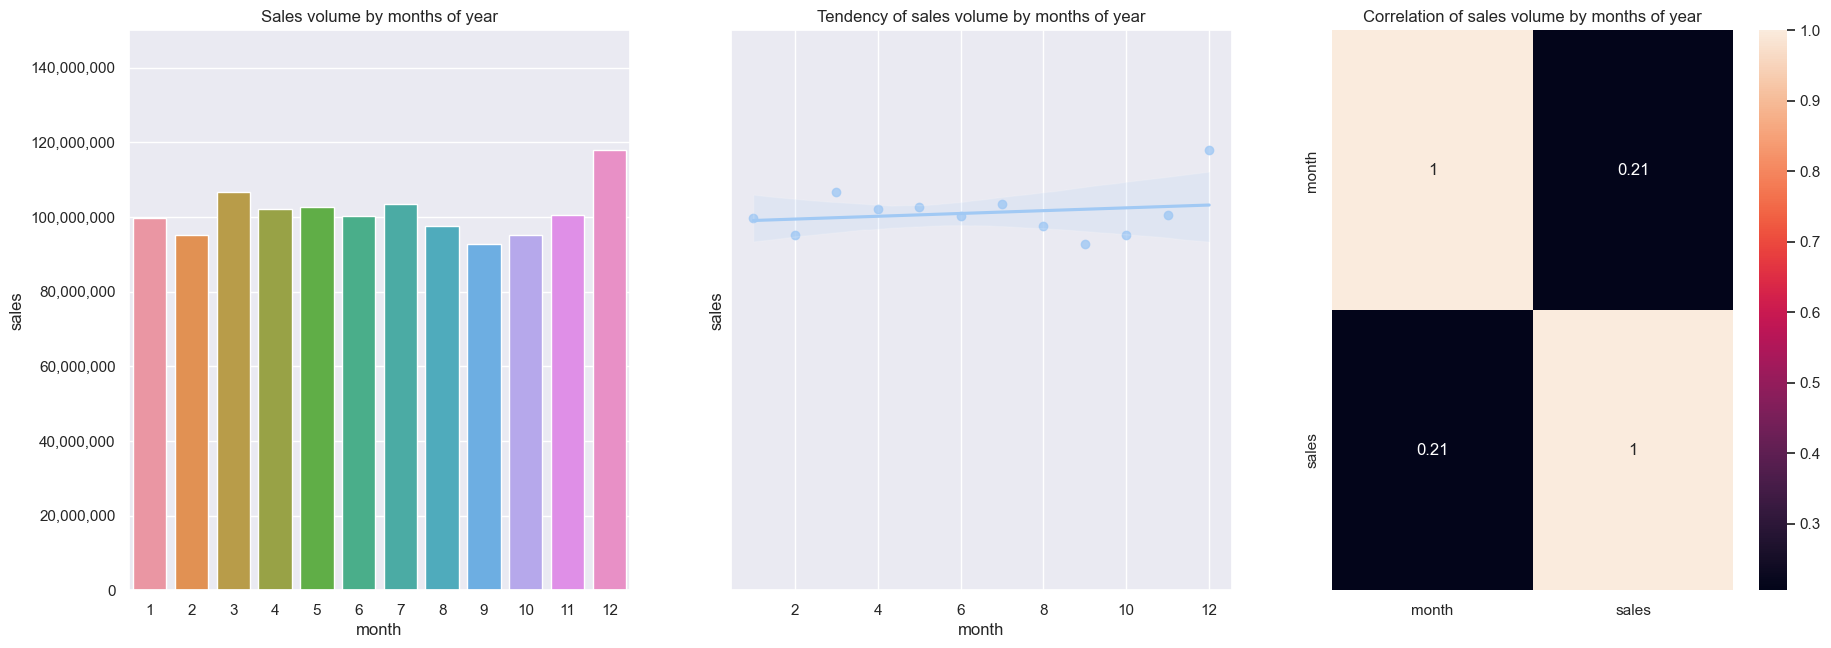

In [50]:
plt.figure(figsize=(22, 16))

aux1 = df5[df5['year'] != 2015][['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(2, 3, 1)
ax1 = sns.barplot(data=aux1, x='month', y='sales')
ax1.set_title('Sales volume by months of year') 
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim([0, 150000000])

plt.subplot(2, 3, 2)
ax2 = sns.regplot(data=aux1, x='month', y='sales')
ax2.set_title('Tendency of sales volume by months of year') 
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim([0, 150000000])
plt.yticks([])

plt.subplot(2, 3, 3)
ax3 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax3.set_title('Correlation of sales volume by months of year') 

plt.show()

### H10. Stores should sell more after the 10th day of each month
**(TRUE)** - The majority of sales happen after the 10th day, but also, we have to consider that we have a larger window in the second half (20 days vs 10 days)

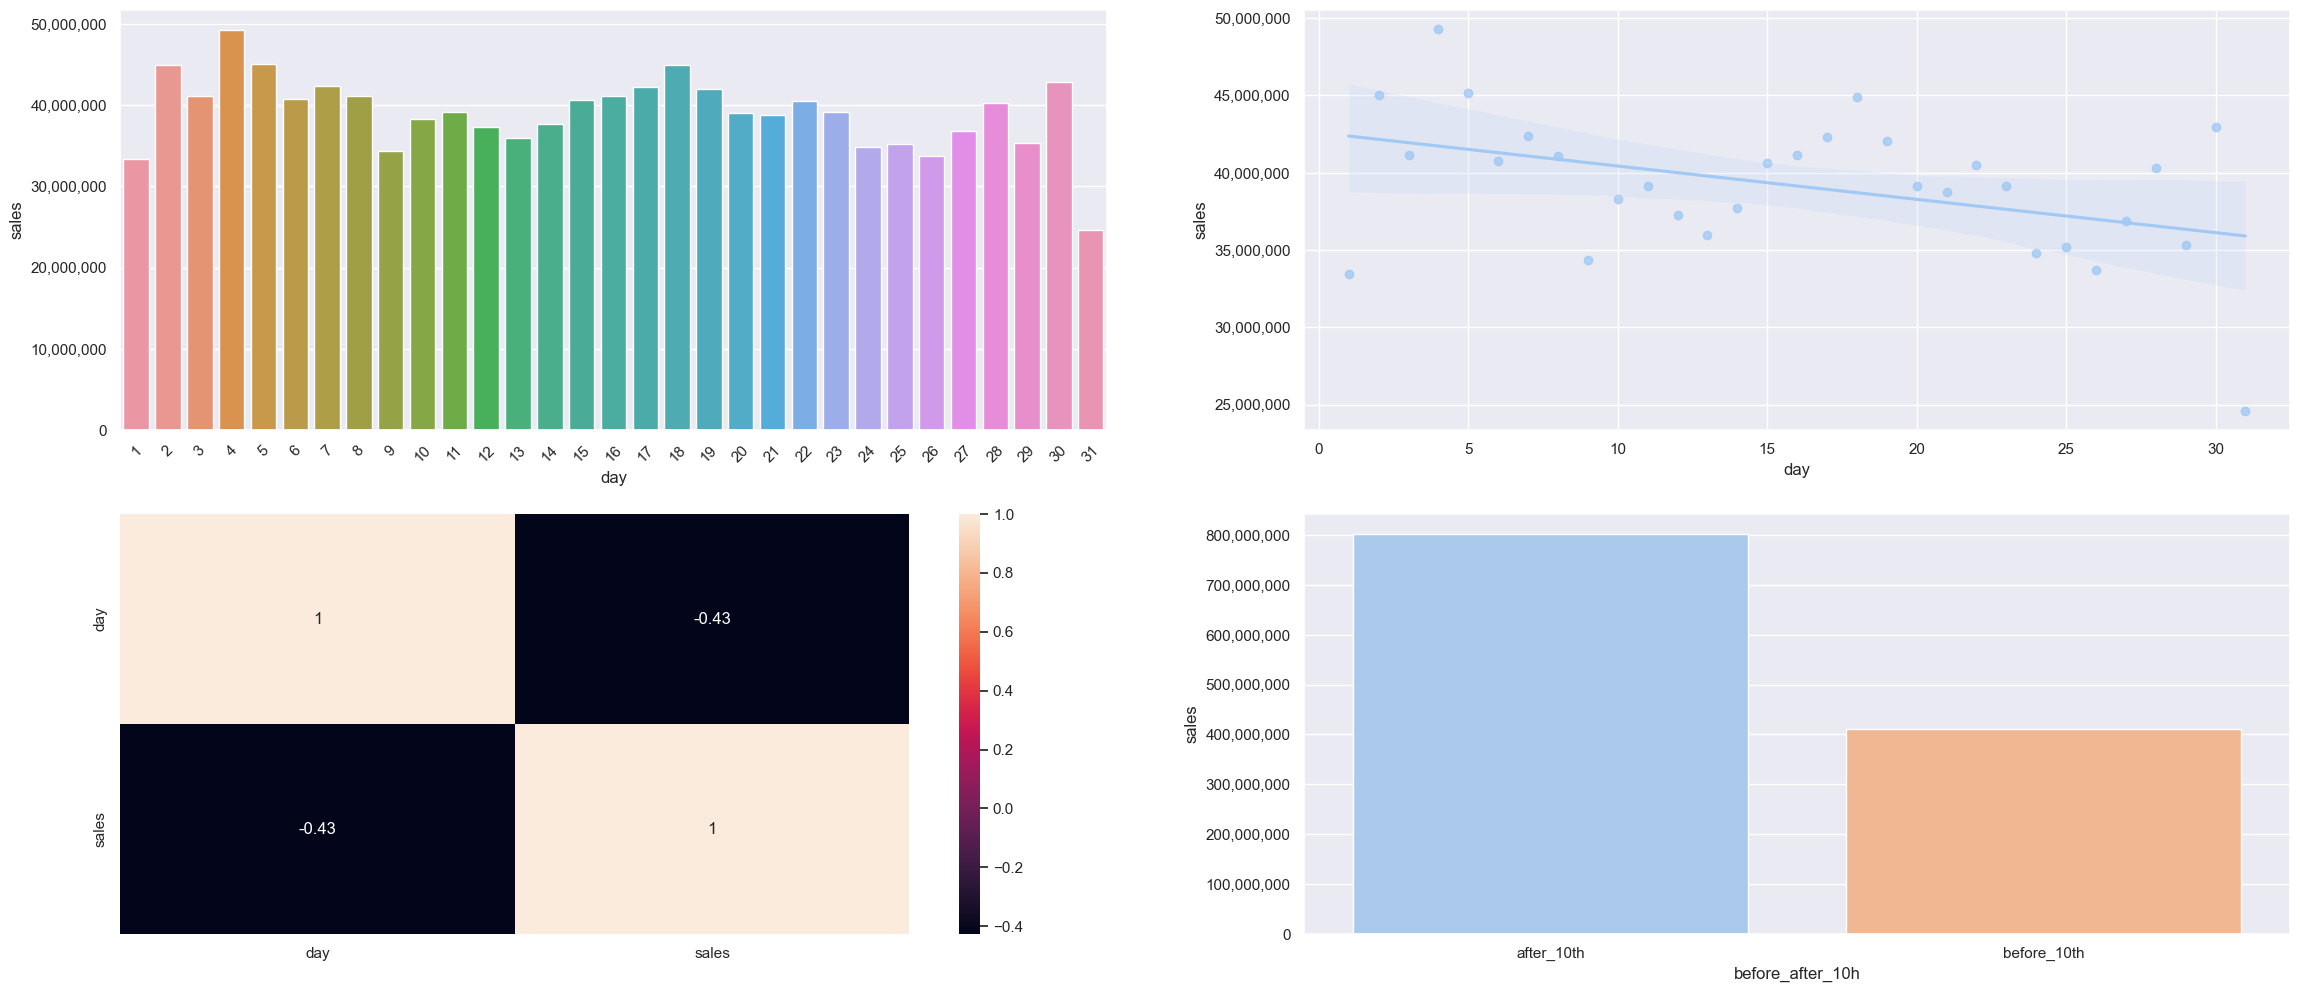

In [51]:
plt.figure(figsize=(28, 12))

aux1 = df5[df5['year'] != 2015][['day', 'sales']].groupby('day').sum().reset_index()
aux1['before_after_10h'] = aux1['day'].apply(lambda x: 'before_10th' if x <=10 else 'after_10th')
aux2 = aux1[['sales', 'before_after_10h']].groupby('before_after_10h').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(data=aux1, x='day', y='sales')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(2, 2, 2)
sns.regplot(data=aux1, x='day', y='sales')
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2, 2, 4)
sns.barplot(data=aux2, x='before_after_10h', y='sales')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

### H11. Stores should sell less on weekends 
**(TRUE)** - On the 6th and 7th day, the number of sales drops, especially on day 7th, which is sunday.

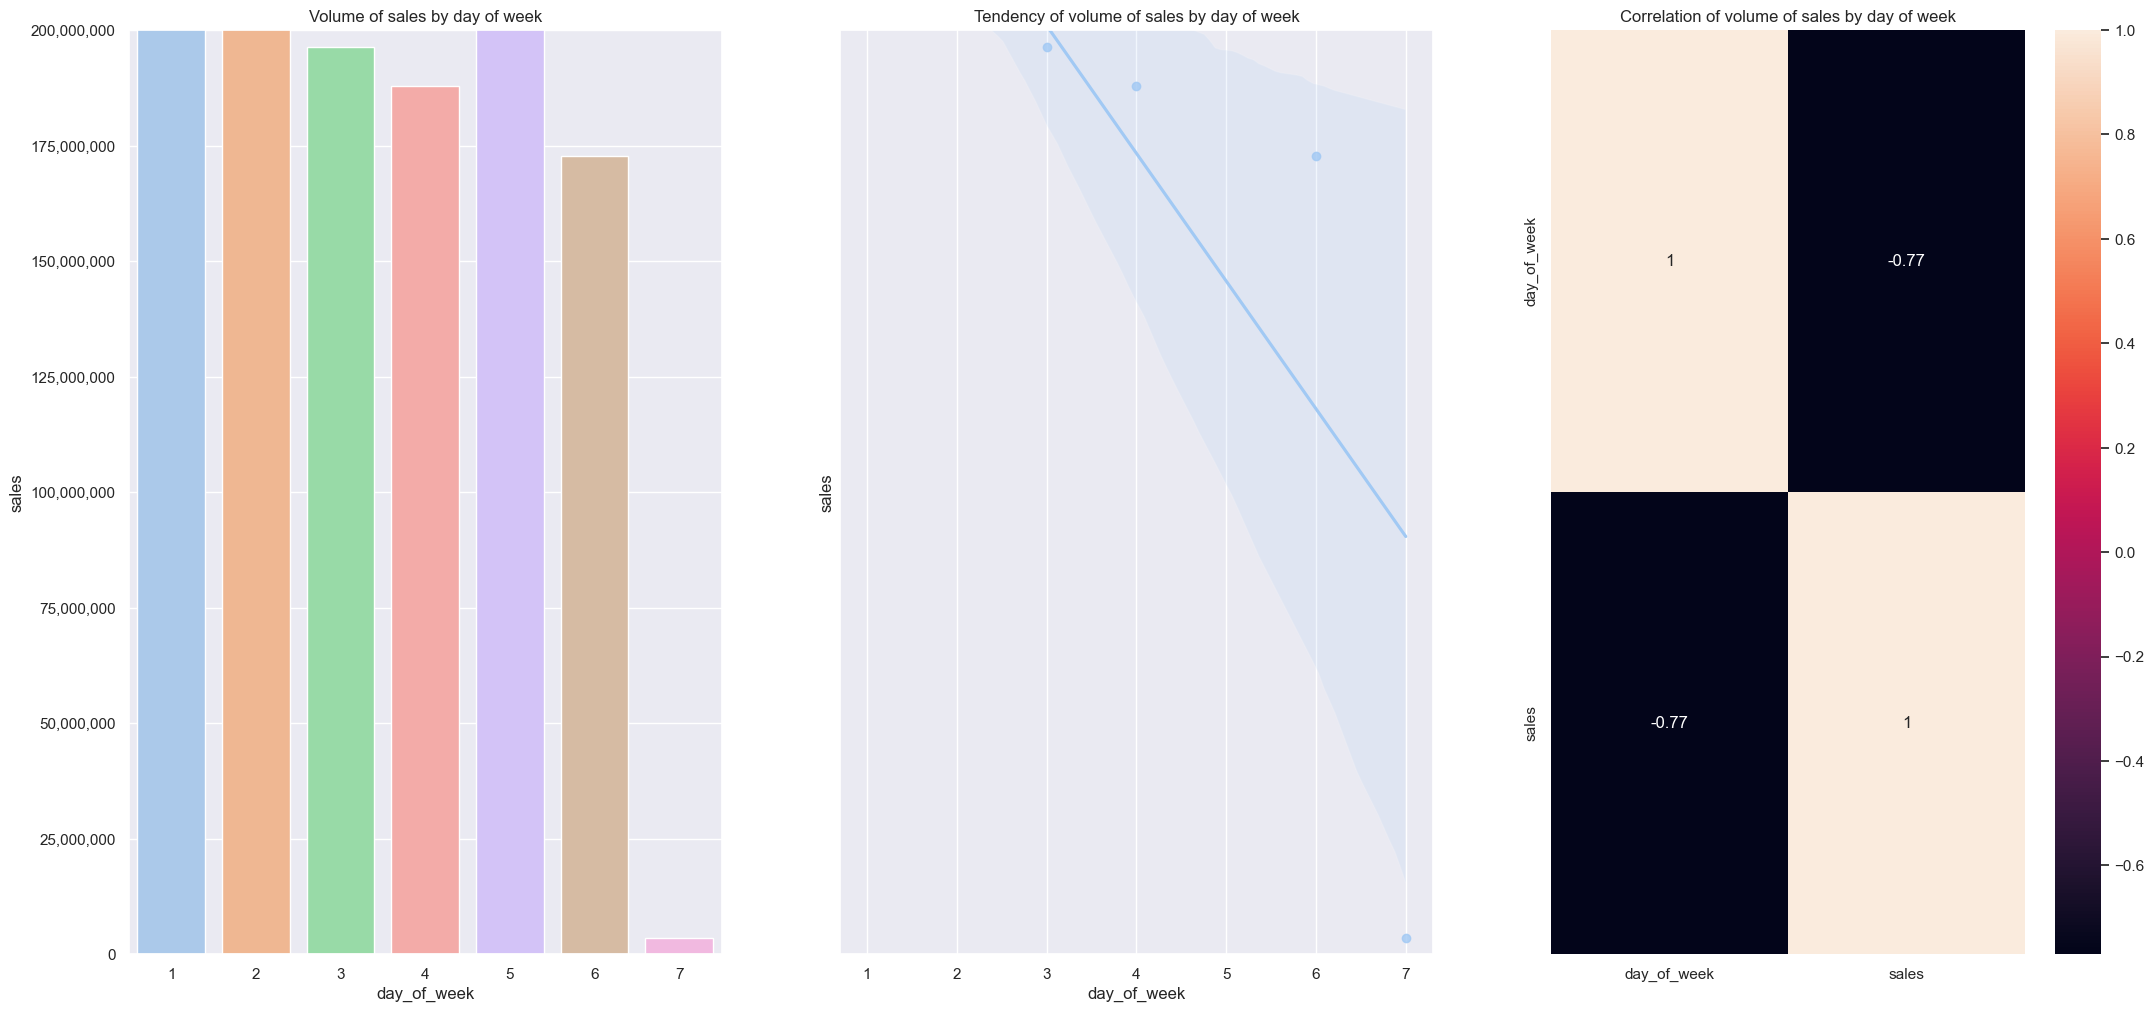

In [52]:
plt.figure(figsize=(26, 12))

aux1 = df5[df5['year'] != 2015][['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
ax1 = sns.barplot(data=aux1, x='day_of_week', y='sales')
ax1.set_title('Volume of sales by day of week')
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim([0, 200000000])

plt.subplot(1, 3, 2)
ax2 = sns.regplot(data=aux1, x='day_of_week', y='sales')
ax2.set_title('Tendency of volume of sales by day of week')
plt.gca().yaxis.set_major_formatter(formatter)
plt.ylim([0, 200000000])
plt.yticks([])

plt.subplot(1, 3, 3)
ax3 = sns.heatmap(aux1.corr(method='pearson'), annot=True)
ax3.set_title('Correlation of volume of sales by day of week')

plt.show()

### H12. Stores should sell less during school holidays
**(TRUE)** - Of course, we have to consider that the majority of time, it is not a school holiday.

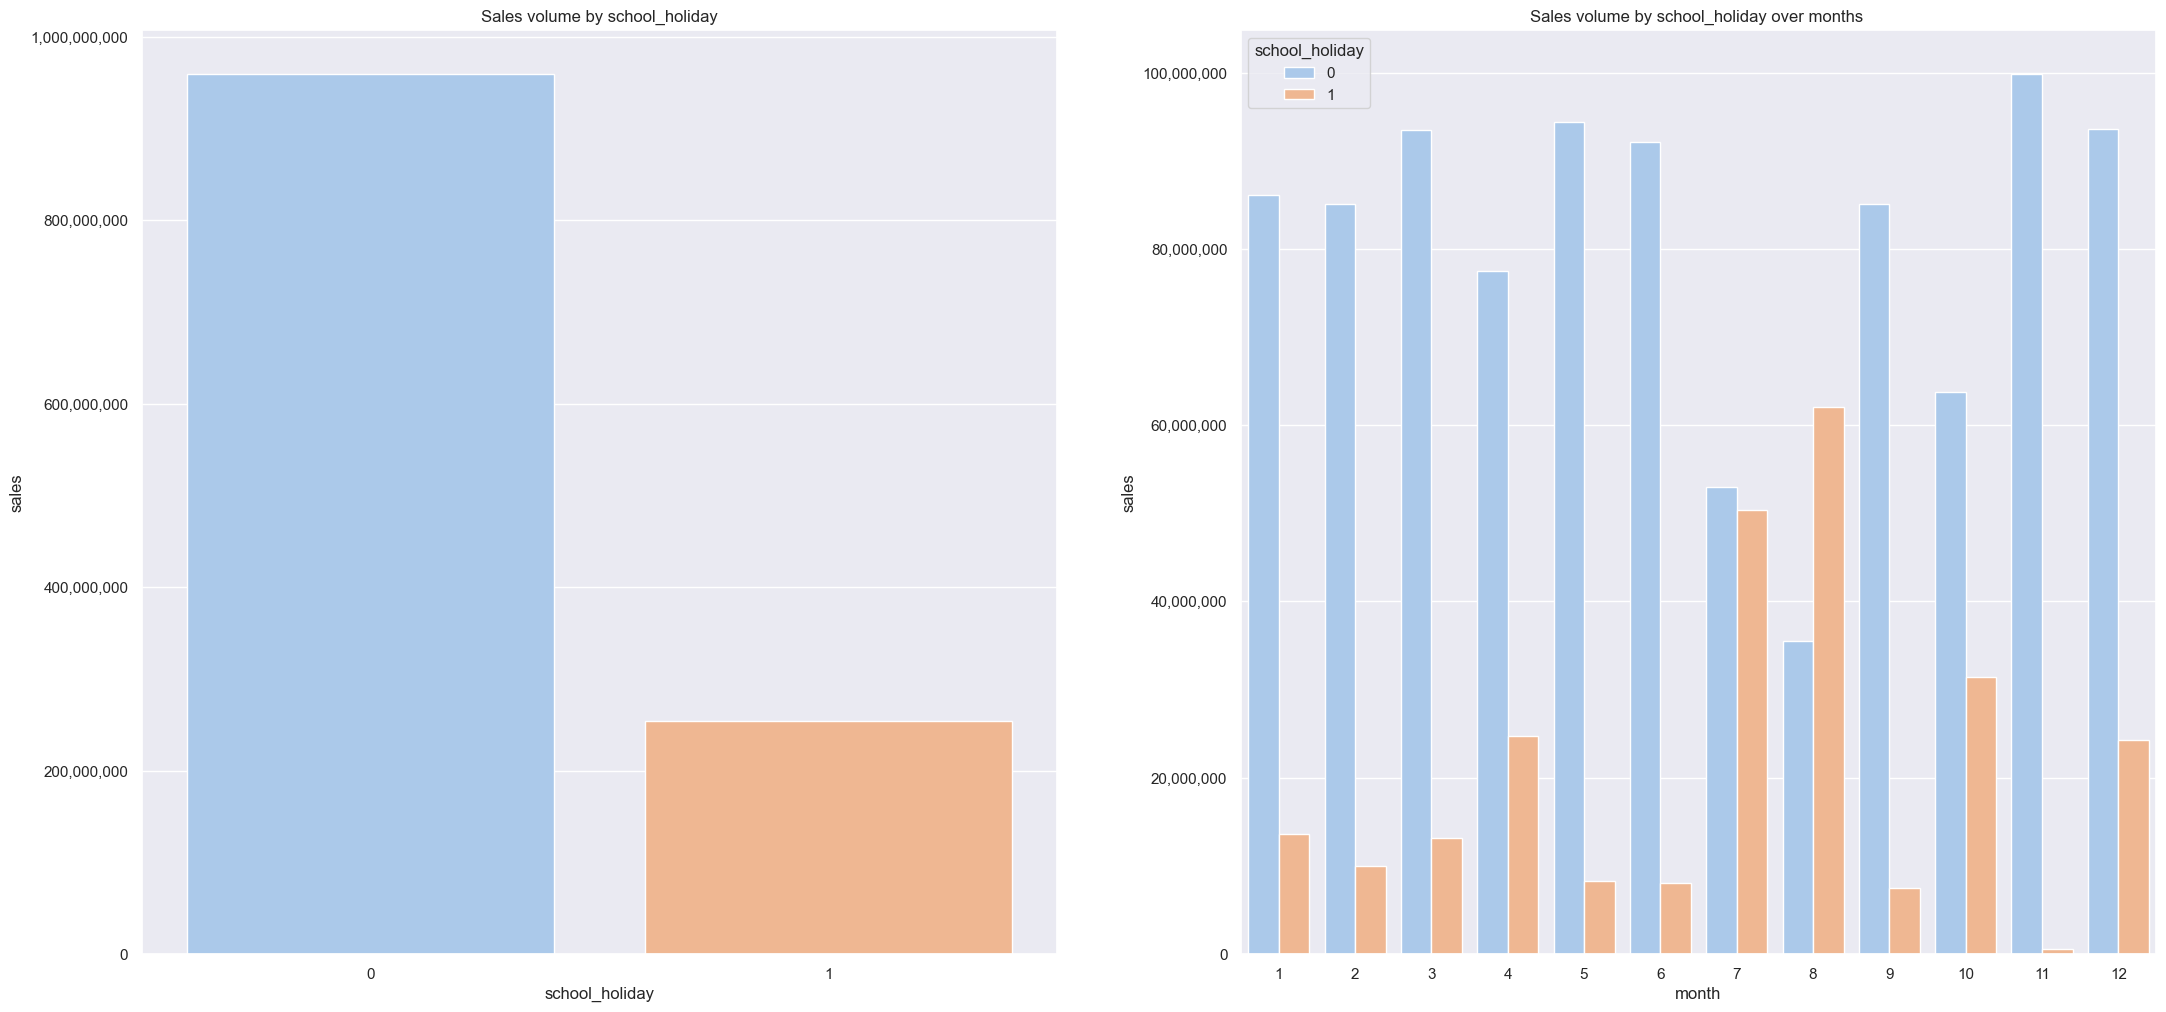

In [53]:
plt.figure(figsize=(26, 12))

aux1 = df5[df5['year'] != 2015][['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(1, 2, 1)
ax1 = sns.barplot(data=aux1, x='school_holiday', y='sales')
ax1.set_title('Sales volume by school_holiday')
plt.gca().yaxis.set_major_formatter(formatter)

aux2 = df5[df5['year'] != 2015][['school_holiday', 'month', 'sales']].groupby(['school_holiday', 'month']).sum().reset_index()

plt.subplot(1, 2, 2)
ax2 = sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday')
ax2.set_title('Sales volume by school_holiday over months ')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

## 5.3 Multivariate Analysis

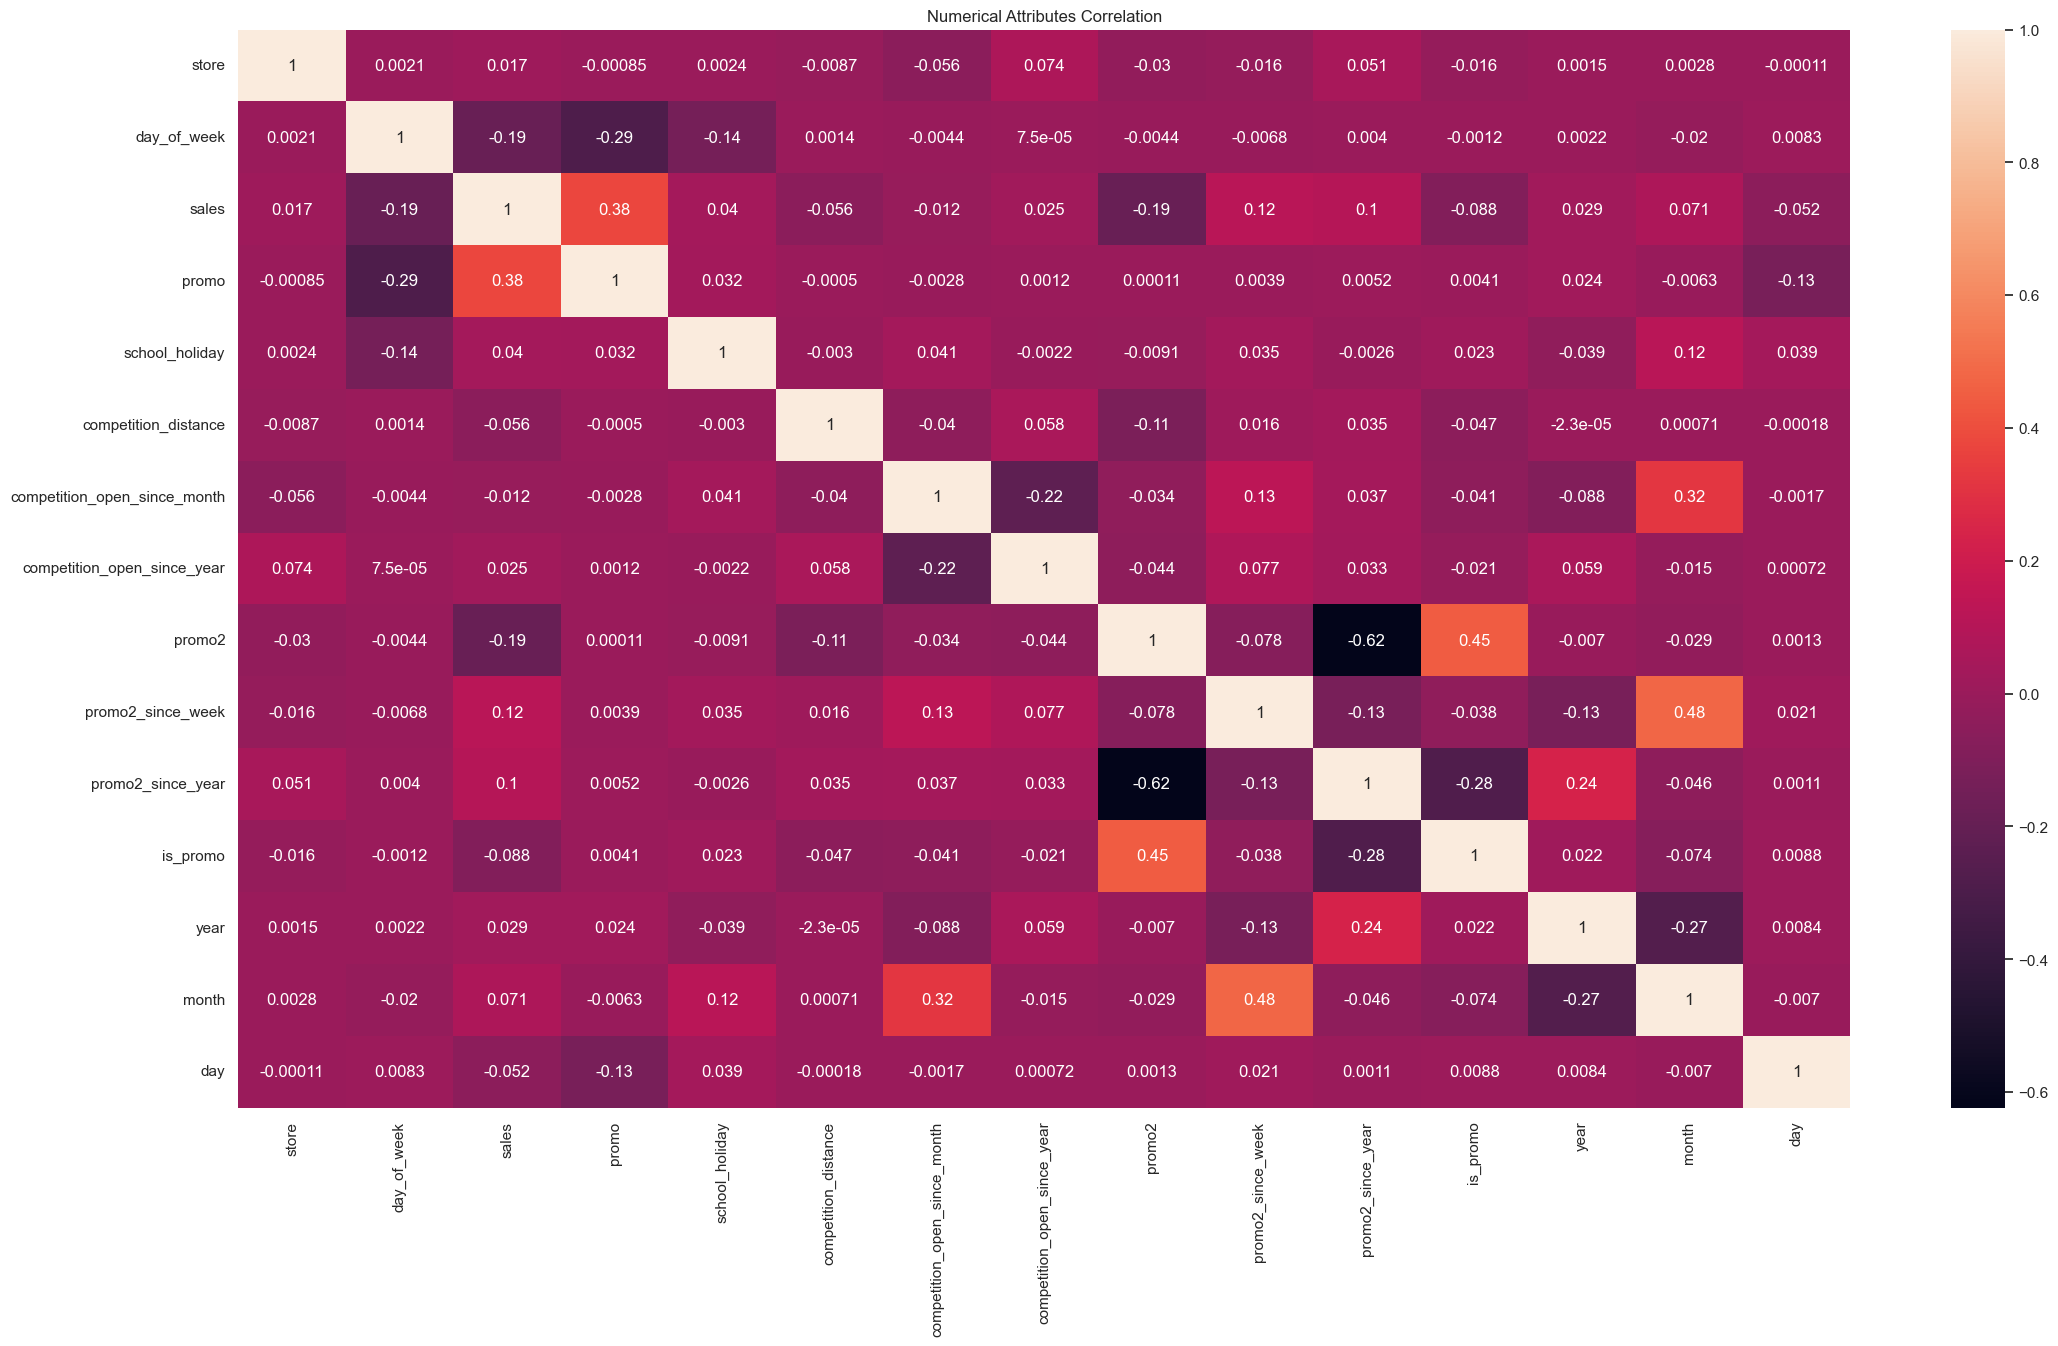

In [54]:
plt.figure(figsize=(26, 14))
correlation = num_att.corr(method='pearson')

ax1 = sns.heatmap(correlation, annot=True)
ax1.set_title('Numerical Attributes Correlation')
plt.show()

### 4.3.2 Categorical Attributes

In [55]:
cat_att = df4.select_dtypes(include=['object'])
cat_att.drop(columns='year_week', inplace=True)

#### 4.3.2.1 Contigency Tables

In [56]:
holiday_vs_store = pd.crosstab(cat_att['state_holiday'], cat_att['store_type'])
holiday_vs_assortment = pd.crosstab(cat_att['state_holiday'], cat_att['assortment'])
store_vs_assortment = pd.crosstab(cat_att['store_type'], cat_att['assortment'])

In [57]:
holiday_vs_store

store_type,a,b,c,d
state_holiday,,,,
christmas,2,14,0,0
easter_holiday,9,22,0,0
no_holiday,121265,3292,37549,64829
public_holiday,65,58,26,21


In [58]:
holiday_vs_assortment

assortment,basic,extended,extra
state_holiday,,,
christmas,12,2,2
easter_holiday,16,9,6
no_holiday,125755,100463,717
public_holiday,99,51,20


In [59]:
store_vs_assortment

assortment,basic,extended,extra
store_type,,,
a,80416,40925,0
b,2641,0,745
c,16653,20922,0
d,26172,38678,0


#### 4.3.2.1 Calculate Cramer's V

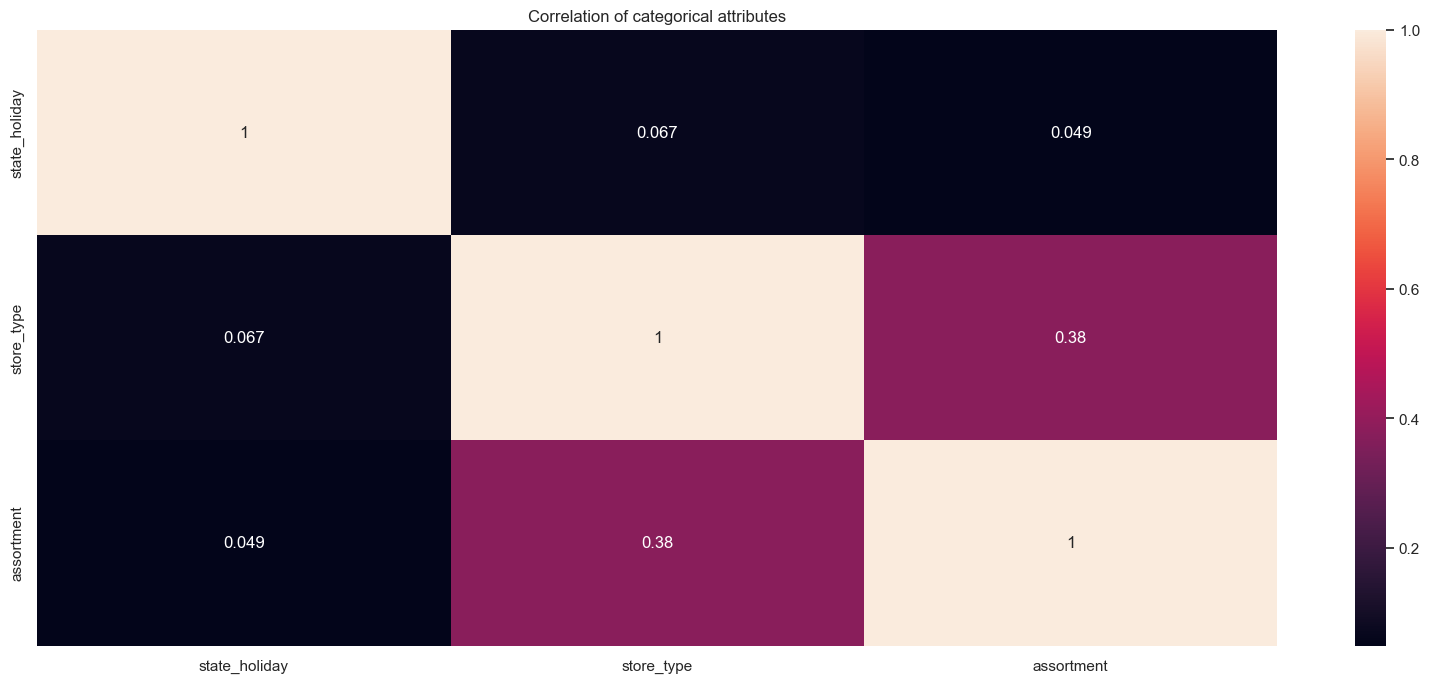

In [60]:
# creating all possible combinations
aux1 = cramers_v(cat_att, 'state_holiday', 'state_holiday')
aux2 = cramers_v(cat_att, 'state_holiday', 'store_type')
aux3 = cramers_v(cat_att, 'state_holiday', 'assortment')

aux4 = cramers_v(cat_att, 'store_type', 'state_holiday')
aux5 = cramers_v(cat_att, 'store_type', 'store_type')
aux6 = cramers_v(cat_att, 'store_type', 'assortment')

aux7 = cramers_v(cat_att, 'assortment', 'state_holiday')
aux8 = cramers_v(cat_att, 'assortment', 'store_type')
aux9 = cramers_v(cat_att, 'assortment', 'assortment')

# create dataset
aux10 = pd.DataFrame({
    'state_holiday': [aux1, aux2, aux3],
    'store_type': [aux4, aux5, aux6],
    'assortment': [aux7, aux8, aux9],
})

# rename index to the same name of columns
aux10 = aux10.set_index(aux10.columns)

# create chart
ax1 = sns.heatmap(aux10, annot=True)
ax1.set_title('Correlation of categorical attributes')
plt.show()

# 6. DATA PREPARATION

In [61]:
df6 = df5.copy()

## 6.1 Normalization

We don't have any feature that follows exactly a normal distribution.

## 6.2 Rescaling

In [62]:
df6 = rescaling(df6)

## 6.3 Transformation

### 6.3.1 Encoding

In [63]:
df6 = encoding(df6)

### 6.3.2 Transformation

In [64]:
# transform targe variable into log 1p to rescale
df6['sales'] = np.log1p(df6['sales'])

In [65]:
df6 = transformation(df6)

# 7. FEATURE SELECTION

## 7.1 Dropping Features 

In [66]:
df7 = df6.copy()

In [67]:
cols_drop = ['day', 'month', 'day_of_week', 'week', 'promo2_since_week', 'competition_open_since_month']
df7.drop(cols_drop, axis=1, inplace=True)

## 7.2 Train/Test Split

Our train/test split strategy will be a little different than selecting it randomly. Since we have cyclical data, if we use the random selection strategy, we will have train data blended with test, which may cause overfitting.

Being so, we have set the strategy as selecting **TEST data as all examples of last 6 weeks within dataset**, and **TRAIN test will be previous data**.

The date that represents this breakage is **2015-06-19**

In [68]:
# select train data
X_train = df7.loc[df7['date'] < '2015-06-19']
y_train = X_train['sales']

# select test data
X_test = df7.loc[df7['date'] >= '2015-06-19']
y_test = X_test['sales']

# checking train/test size 
print(f'Original dataset have {df7.shape[0]} rows')
print(f'Train have {(X_train.shape[0]/df7.shape[0]):.2%} and test have {(X_test.shape[0]/df7.shape[0]):.2%}\n')

# checking min-max date of each dataset
print(f'Train min date {X_train["date"].min()}')
print(f'Train max date {X_train["date"].max()}\n')

print(f'Test min date {X_test["date"].min()}')
print(f'Test max date {X_test["date"].max()}')

Original dataset have 227152 rows
Train have 95.09% and test have 4.91%

Train min date 2013-01-01 00:00:00
Train max date 2015-06-18 00:00:00

Test min date 2015-06-19 00:00:00
Test max date 2015-07-31 00:00:00


## 7.3 Boruta implementation

In [69]:
# define random forest regressor
#rf = RandomForestRegressor(n_jobs=1)

# adjust train and test data as arrays
#X_train_array = X_train.drop(columns=['date', 'sales', 'year_week', 'competition_since_date', 'promo_since'], axis=1).values
#y_train_array = y_train.values.ravel()

# define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1).fit(X_train_array, y_train_array)

In [70]:
# boruta mask return whether the ith column was selected or rejected (true of false)
#boruta_mask = boruta.support_
#features = X_train.drop(columns=['date', 'sales', 'year_week', 'competition_since_date', 'promo_since'], axis=1).columns

# save the columns selected by the algorithm
#boruta_cols = [features[i] for i in range(len(features)) if boruta_mask[i]]

# Taking bivariate analysis into account, we will select the following features to add to the final model: 
#other_cols = ['year', 'month_sin', 'week_sin']

# concatenate columns
selected_cols = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_year', 'promo2',
                 'promo2_since_year', 'competition_number_months', 'promo_number_weeks', 'day_sin', 'day_cos', 'month_cos', 'month_sin',
                 'day_of_week_sin', 'day_of_week_cos', 'week_cos', 'week_sin', 'year', 'school_holiday', 'state_holiday_christmas', 
                 'state_holiday_easter_holiday', 'state_holiday_no_holiday', 'state_holiday_public_holiday']

# 8. MACHINE LEARNING MODELING

In [71]:
# create copies to work with train and test datasets
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [72]:
# dropping date features from train and test dataset
X_train_fs = X_train_copy.drop(columns=['date', 'sales', 'year_week', 'competition_since_date', 'promo_since'], axis=1)
X_test_fs = X_test_copy.drop(columns=['date', 'sales', 'year_week', 'competition_since_date', 'promo_since'], axis=1)

# rearrange train and test datasets to receive the columns that we will use 
X_train = X_train_fs.loc[:, selected_cols]
X_test = X_test_fs.loc[:, selected_cols]

# Adding date column to perform time series cross validation
X_train['date'] = X_train_copy['date']
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

## 8.1 Average

In [73]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# predict
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_average = aux1['predictions']

# performance 
baseline_result = ml_performance('average_model', np.expm1(y_test), np.expm1(yhat_average))
baseline_result

,model_name,MAE,MAPE,RMSE,R2_SCORE
0,average_model,1383.92,0.2117,1844.72,0.6349


## 8.2 Linear Regression

In [74]:
lr = LinearRegression()
lr_cv = cross_validation_ts(X_train, y_train, 'linear_regression', lr)
lr_cv

,MODEL,MAE_avg,MAPE_avg,RMSE_avg,R2_avg
0,linear_regression,2143.73 +/- 174.6,0.36 +/- 0.05,2953.42 +/- 144.45,0.16 +/- 0.06


## 8.3 Linear Regression Regularized - Lasso

In [75]:
llr = Lasso(alpha=0.01)
lasso_cv = cross_validation_ts(X_train, y_train, 'lasso_regression', llr)
lasso_cv

,MODEL,MAE_avg,MAPE_avg,RMSE_avg,R2_avg
0,lasso_regression,2055.42 +/- 96.42,0.33 +/- 0.01,2945.09 +/- 162.47,0.16 +/- 0.04


## 8.4 KNN (K-Neareast Neighbors)

In [76]:
knn = KNeighborsRegressor(n_neighbors=7, weights='distance')
knn_cv = cross_validation_ts(X_train, y_train, 'knn_regressor', knn)
knn_cv

,MODEL,MAE_avg,MAPE_avg,RMSE_avg,R2_avg
0,knn_regressor,1024.28 +/- 143.85,0.16 +/- 0.02,1469.17 +/- 243.67,0.79 +/- 0.06


## 8.5 Random Forest Regressor

In [77]:
rfr = RandomForestRegressor(n_estimators=50, n_jobs=-1)
rfr_cv = cross_validation_ts(X_train, y_train, 'random_forest_regressor',  rfr)
rfr_cv

,MODEL,MAE_avg,MAPE_avg,RMSE_avg,R2_avg
0,random_forest_regressor,894.43 +/- 194.97,0.13 +/- 0.02,1415.9 +/- 389.34,0.8 +/- 0.1


## 8.6 XGBoost Regressor

In [78]:
# model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, eta=0.01, subsample=0.7, colsample_bytree=0.9)
xgb_cv = cross_validation_ts(X_train, y_train, 'xgb_regressor', xgb_model)
xgb_cv

,MODEL,MAE_avg,MAPE_avg,RMSE_avg,R2_avg
0,xgb_regressor,6910.49 +/- 203.33,0.99 +/- 0.0,7623.54 +/- 223.8,-4.61 +/- 0.2


## 8.7 Performance

In [79]:
cv_perf = pd.concat([lr_cv, lasso_cv, knn_cv, rfr_cv, xgb_cv], ignore_index=True)
cv_perf.sort_values('RMSE_avg')

,MODEL,MAE_avg,MAPE_avg,RMSE_avg,R2_avg
3,random_forest_regressor,894.43 +/- 194.97,0.13 +/- 0.02,1415.9 +/- 389.34,0.8 +/- 0.1
2,knn_regressor,1024.28 +/- 143.85,0.16 +/- 0.02,1469.17 +/- 243.67,0.79 +/- 0.06
1,lasso_regression,2055.42 +/- 96.42,0.33 +/- 0.01,2945.09 +/- 162.47,0.16 +/- 0.04
0,linear_regression,2143.73 +/- 174.6,0.36 +/- 0.05,2953.42 +/- 144.45,0.16 +/- 0.06
4,xgb_regressor,6910.49 +/- 203.33,0.99 +/- 0.0,7623.54 +/- 223.8,-4.61 +/- 0.2


Even Random Forest performed better, the choosen algorithm is **K-Nearest Neighbor**. Though Random Forest had performed better, KNN isn't too far, and it is a lighter and faster model, which is good for storage and running it again.

## 8.8 FINE TUNNING

In [131]:
# create a dictionary of parameter values values
#params = {'n_neighbors': [3, 5, 7, 9],
          #'weights': ['uniform', 'distance'],
          #'p': [1, 2]} # 1 for manhattan and 2 for euclidian

# declate the model
#knn_gs = KNeighborsRegressor()

# create grid search object
#grid_search = GridSearchCV(knn_gs, params, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)

# train using grid search
#grid_search.fit(X_train.iloc[:, :-1], y_train)

# collect the best params
#best_params = grid_search.best_params_

# collect the best model
#best_model = grid_search.best_estimator_

# 9 FINAL MODEL AND PREDICTIONS

In [132]:
with open('C:/Users/andre/repos/ds-em-producao/models/rossman_model_v1.pkl', 'rb') as file:
    model = pickle.load(file)

In [133]:
# define model
#model = KNeighborsRegressor(n_neighbors = 9, p = 1, weights = 'distance')

# train
model.fit(X_train.iloc[:, :-1], y_train)

# predict
yhat = model.predict(X_test)

# performance
model_result = ml_performance('knn_regressor', np.expm1(y_test), np.expm1(yhat))

# 10. MODEL PERFORMANCE AND ERROR INTERPRETATION

## 10.1 Business Performance

In [134]:
# adding sales, the predictions and date for test dataset
df10 = X_test.copy()
df10['sales'] = np.expm1(y_test)
df10['prediction'] = np.expm1(yhat)
df10['date'] = X_test_copy['date']

In [135]:
# group predictions by store and take its total sales for the last 6 weeks
aux1 = df10[['sales', 'store', 'prediction']].groupby('store').sum().reset_index()

# MAE and MAPE
mae = df10[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['prediction'])).reset_index().rename(columns={0:'MAE'})
mape = df10[['store', 'sales', 'prediction']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['prediction'])).reset_index().rename(columns={0:'MAPE'})

# Merging dataframes
aux1 = pd.merge(pd.merge(aux1, mae, how='inner', on='store'), mape, how='inner', on='store')
aux1['best_scenario'] = aux1.apply(lambda x: x['prediction'] * (1 + x['MAPE']), axis=1)
aux1['worst_scenario'] = aux1.apply(lambda x: x['prediction'] * (1 - x['MAPE']), axis=1)

In [120]:
aux1

,store,sales,prediction,MAE,MAPE,best_scenario,worst_scenario
0,4,369378.0,355018.870722,883.778153,0.084856,385144.276121,324893.465324
1,5,166905.0,169951.247343,405.833573,0.102776,187418.177974,152484.316711
2,12,281538.0,276281.950911,721.625318,0.092033,301708.875176,250855.026646
3,18,258062.0,237247.415311,643.171410,0.081507,256584.737578,217910.093044
4,19,245731.0,246287.070345,576.429887,0.089975,268446.727408,224127.413282
...,...,...,...,...,...,...,...
295,1106,186960.0,176562.429843,401.543665,0.076383,190048.869976,163075.989711
296,1107,233570.0,237842.634186,740.614939,0.122884,267069.571358,208615.697014
297,1109,179198.0,184500.138204,530.548553,0.109908,204778.228068,164222.048340
298,1110,164859.0,167582.554241,390.370689,0.091146,182856.992678,152308.115805


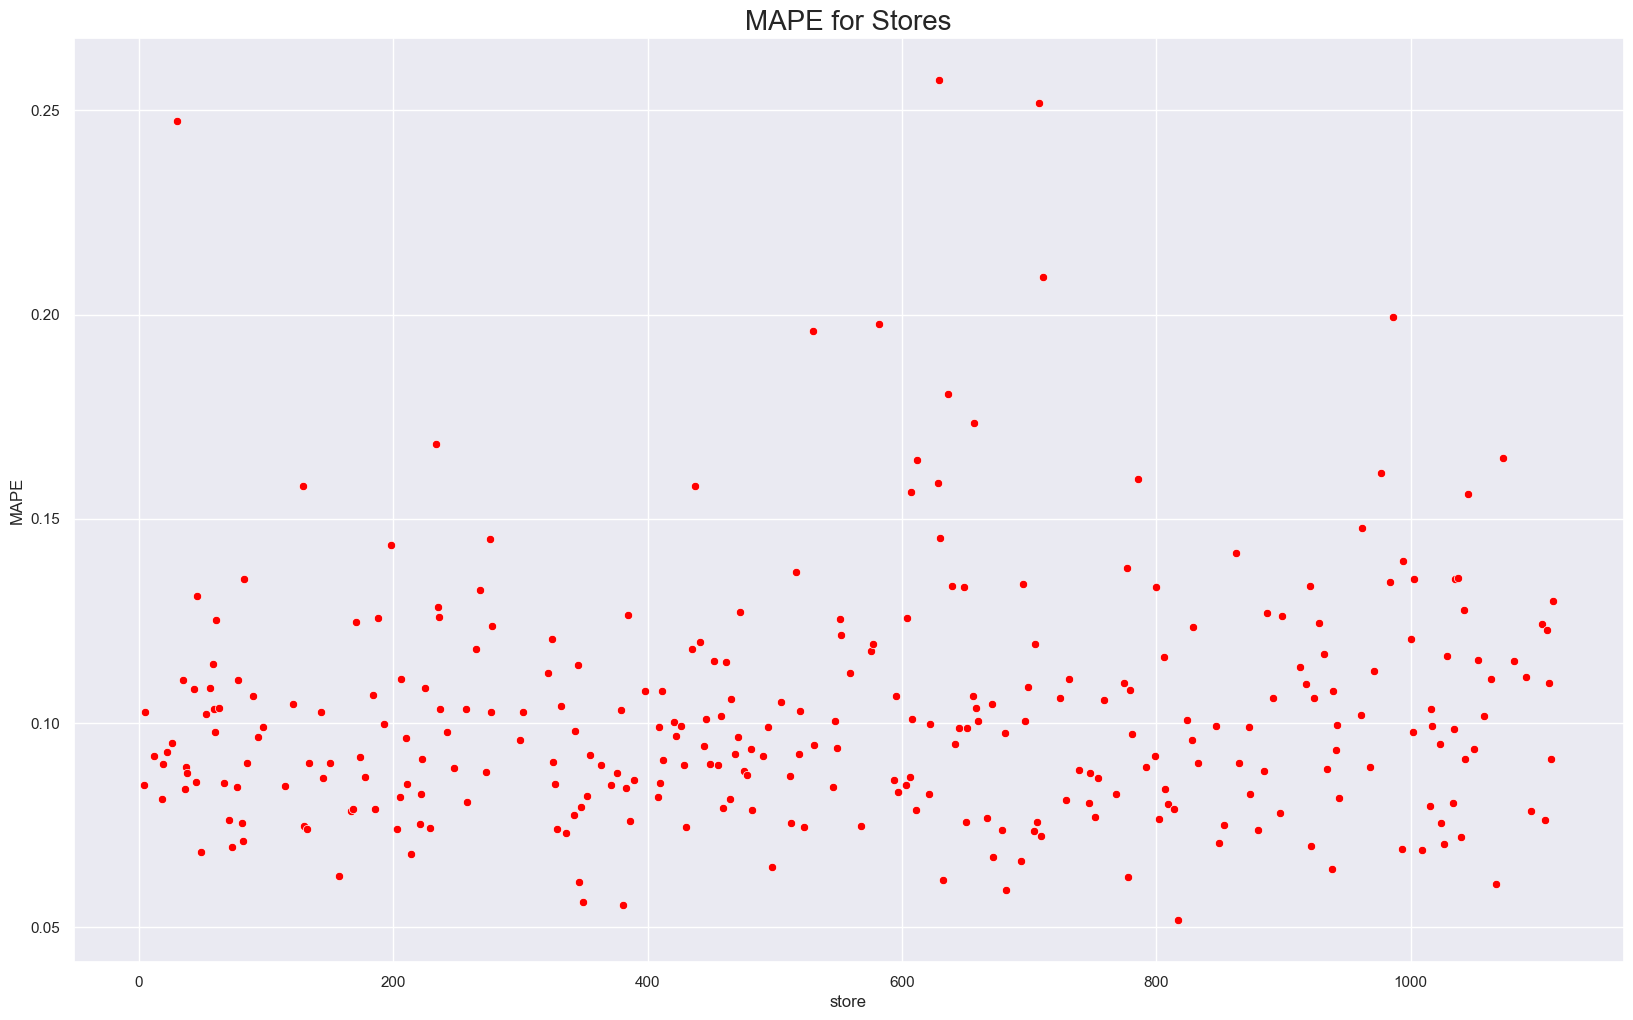

In [121]:
# Plot of MAPE for each stores
fig, ax = plt.subplots(figsize=(20, 12))

sns.scatterplot(data=aux1, x='store', y='MAPE', color='red', ax=ax)
ax.set_title('MAPE for Stores', fontdict = {'fontsize': 20})
plt.show()

## 10.2 Total Performance

In [122]:
aux2 = aux1[['prediction', 'best_scenario', 'worst_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'scenario', 
                                                                                                                                0: 'revenue'})
aux2['revenue'] = aux2['revenue'].map('R${:,.2f}'.format)
aux2

,scenario,revenue
0,prediction,"R$77,916,381.17"
1,best_scenario,"R$85,683,131.96"
2,worst_scenario,"R$70,149,630.37"


## 10.3 Machine Learning Performance

In [123]:
model_result

,model_name,MAE,MAPE,RMSE,R2_SCORE
0,knn_regressor,682.1,0.1024,928.92,0.9074


In [124]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat))
print(f'The MPE result is: {round(mpe, 4)}')

The MPE result is: -0.0192


In [125]:
# create error and assertiveness features
df10['error'] = df10['sales'] - df10['prediction']
df10['assertiveness'] = df10['prediction']/df10['sales']

**Assertiveness is the % of the prediction that was reached (ex: for a real value of 100, if the prediction is 102, we had an assertiveness of 102%)**

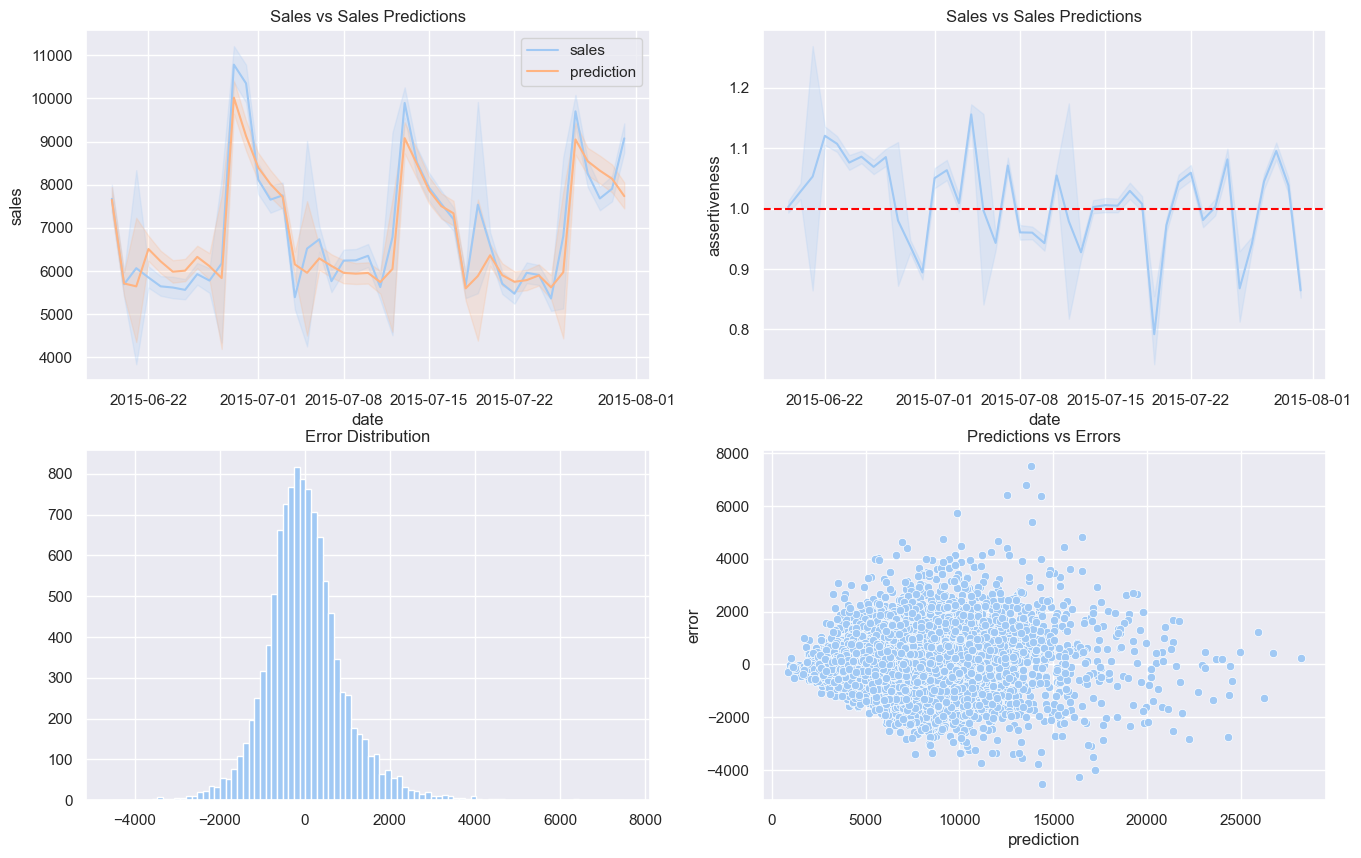

In [126]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

# 1st plot - sales vs errors
sns.lineplot(data=df10, x='date', y='sales', label='sales', ax=axs[0, 0])
sns.lineplot(data=df10, x='date', y='prediction', label='prediction', ax=axs[0, 0])
axs[0, 0].set_title('Sales vs Sales Predictions')

# 2nd plot - sales vs errors
sns.lineplot(data=df10, x='date', y='assertiveness', ax=axs[0, 1])
axs[0, 1].axhline(1, linestyle='--', color='red')
axs[0, 1].set_title('Sales vs Sales Predictions')

# 3rd plot - sales vs errors
axs[1, 0].hist(df10['error'], bins=90, density=False)
axs[1, 0].set_title('Error Distribution')


# 4th plot - sales vs errors
sns.scatterplot(data=df10, x='prediction', y='error', ax=axs[1, 1])
axs[1, 1].set_title('Predictions vs Errors')

plt.show()

# 11. SAVE MODEL

In [127]:
# save predictions to csv file
result = aux1[['store', 'prediction', 'MAPE', 'best_scenario', 'worst_scenario']]
result.to_csv('predictions/sales_prediction_v1.csv')

In [130]:
#with open('C:/Users/andre/repos/ds-em-producao/models/rossman_model_v1.pkl', 'wb') as file:
    #pickle.dump(model, file)

# 12. DEPLOY

In [166]:
class Rossmann(object):

    def __init__():
        pass

    def data_cleaning(self, df):

        # Saving columns name to a new variable
        cols_name = df.columns.to_list()

        # Create a lambda function to pass columns name to snake case
        transform_snake_case = lambda x: inflection.underscore(x)

        # Apply function and save new names on another list
        cols_name_new = list(map(transform_snake_case, cols_name))
        
        # Renaming
        df.columns = cols_name_new 
        df['date'] = pd.to_datetime(df['date'])

        # fill na
        df = fill_nas(df)

        return df